# Analyze sessions in batch from Phase 1 of AdaDrive (work in progress)

In [1]:
import sys
 
# setting path
sys.path.append('..')

from mna.utils.rnapp_data_format import read_all_lslpresets, return_metadata_from_name, event_data_from_data
import pickle, os
import pandas as pd
import numpy as np
import seaborn as sns
from IPython.display import display

import matplotlib.pyplot as plt
from mna.sessions.eye_session import process_session_eye
from mna.sessions.eeg_session import process_session_eeg
from mna.sessions.motor_session import process_session_motor
from mna.sessions.ecg_session import process_session_ecg
from os import listdir
from os.path import isfile, join
from mna.utils.rnapp_data_format import read_all_lslpresets, return_metadata_from_name, event_data_from_data
import pickle
from statannotations.Annotator import Annotator
from collections import defaultdict
from scipy import stats
import mne
import glob 
import random
import re

# 1. Read a RN App, converted pkl file, and create the metadata and data structure

In [2]:
import matplotlib
matplotlib.use('Agg')

# Batch convert raw files into pickle

In [3]:
from mna.utils.rnapp_data_format import read_all_files

In [4]:
# loop over the list of csv files
def read_motor_csvs():
    csv_files = glob.glob(os.path.join(output_dir, "ppid*_motor.csv"))
    all_dfs = None
    for f in csv_files:
        # read the csv file
        if not type(all_dfs)==pd.core.frame.DataFrame:
            all_dfs = pd.read_csv(f)
        else:
            all_dfs = pd.concat([all_dfs, pd.read_csv(f)], ignore_index=True)
    all_dfs = all_dfs[all_dfs.columns.drop(list(all_dfs.filter(regex='Unnamed')))]
    return all_dfs

def get_motor_epochs():
    epochs_files = glob.glob(os.path.join(output_dir, "**/*ica_epochs.pickle"), recursive=True)
    motor_epochs = []
    for each_file in epochs_files:
        motor_epochs.append(pickle.load(open(each_file, 'rb')))
    motor_epochs = mne.concatenate_epochs(motor_epochs)
    return motor_epochs

def get_motor_intensity_info(input_df,convert_steer_column=True):
    def str_list_to_list(lst):
        str_single_space = re.sub("\s+", " ", lst.strip())
        str_no_brackets = re.sub("[\[\]]", "", lst)
        return [float(n) for n in str_no_brackets.split()]
    
    if convert_steer_column:
        all_steer_events = input_df['post_steer_event_raw']
        all_steer_events_finalized = all_steer_events.apply(str_list_to_list)
    else: all_steer_events_finalized = input_df['post_steer_event_raw']
    norm_pos = lambda wheel_pos: np.asarray(wheel_pos)/np.asarray(wheel_pos[0])
    final_pos = lambda final_wheel_pos: np.asarray(final_wheel_pos[-1])-np.asarray(final_wheel_pos[0])

    norm_pos_df = all_steer_events_finalized.apply(norm_pos)
    final_pos_df = abs(all_steer_events_finalized.apply(final_pos))
    input_df["Steer_Wheel_Degree"] = abs(all_steer_events_finalized.apply(final_pos))
    all_dfs = []
    for sub in input_df.ppid.unique():
        sub_df = input_df[input_df.ppid==sub]
        sub_df["Steer_Wheel_Degree_Categorical"] = pd.qcut(sub_df.Steer_Wheel_Degree, 2, labels=["Low", "High"]) #2=High, 1 =Low
        sub_df["Steer_Wheel_Degree_Encoded"] = sub_df.Steer_Wheel_Degree_Categorical.replace({'High': 2, 'Low': 1})
        all_dfs.append(sub_df)
    return pd.concat(all_dfs)

# 11-22-22 Meeting

In [5]:
output_dir = '../output/batch_analysis_non_baseline/'
remove_sessions = [(13,1),(15,1),(22,1),(22,102)]

trial_dfs = pd.read_excel(f"{output_dir}all_results.xlsx")
motor_dfs = read_motor_csvs()
# motor_epochs = get_motor_epochs()

## Filter the data to remove sessions we're excluding

In [6]:
trial_dfs['sub_sess'] = trial_dfs.ppid.astype(int).astype(str) + "_" + trial_dfs.session.astype(int).astype(str)
trial_dfs = trial_dfs.loc[~trial_dfs.sub_sess.isin([f"{es[0]}_{es[1]}" for es in remove_sessions])]

motor_dfs['sub_sess'] = motor_dfs.ppid.astype(int).astype(str) + "_" + motor_dfs.session.astype(int).astype(str)
motor_dfs = motor_dfs.loc[~motor_dfs.sub_sess.isin([f"{es[0]}_{es[1]}" for es in remove_sessions])]

motor_epochs_df = motor_epochs.metadata
motor_epochs.metadata['sub_sess'] = motor_epochs_df.ppid.astype(int).astype(str) + "_" + motor_epochs_df.session.astype(int).astype(str)
#(~motor_epochs_df.sub_sess.isin(['13_1', '15_1', '22_1', '22_102']))

motor_epochs = motor_epochs[f"~sub_sess.isin(['13_1', '15_1', '22_1', '22_102'])"]

## Calculate motor degree information

In [7]:
motor_dfs = get_motor_intensity_info(motor_dfs)
motor_epochs.metadata = get_motor_intensity_info(motor_epochs.metadata, convert_steer_column=False)

Replacing existing metadata with 72 columns


In [6]:
# seaborn
sns.set(font_scale=1.2)
sns.set_palette("tab10")
from mna.utils.batch_feature_extraction import clean_up_adadrive_trials

cols_of_interest = ["bpm", "density", "trial_duration", "trial_damage",
                                         "abs_sum_delta_steer_input", "abs_sum_delta_brake_input",
                                         "NSLR_count_Fixation", "NSLR_count_Saccade"]
experimental_cols = ['spoken_difficulty', 'trial_duration', 'density', 'trial_damage']
eye_cols = ['spoken_difficulty','Left Pupil Diameter', "NSLR_count_Fixation", "NSLR_count_Saccade",
            'NSLR_mean_duration_Fixation','NSLR_mean_duration_Saccade',
           'NSLR_first_onset_Fixation', 'NSLR_first_onset_Saccade']
ecg_cols = ['spoken_difficulty','density','bpm','sdnn', 'rmssd','pnn50'] # rmssd = parasympathetic
motor_cols = ['spoken_difficulty','density','abs_sum_delta_steer_input','abs_sum_delta_brake_input', 'abs_sum_delta_throttle_input'] 

def clean_up_trials(input_df):
    all_dfs_final = clean_up_adadrive_trials(input_df.copy())
    # damage change
    all_dfs_final = all_dfs_final.sort_values(by=['ppid', 'session', 'block'])
    # nan, outliers
    for col in cols_of_interest:
        all_dfs_final[col] = all_dfs_final[col].mask(all_dfs_final[col].sub(all_dfs_final[col].mean()).div(all_dfs_final[col].std()).abs().gt(2))
    all_dfs_final['abs_sum_delta_brake_input'] = all_dfs_final['abs_sum_delta_brake_input'].mask(all_dfs_final['abs_sum_delta_brake_input']>.1)

    all_dfs_final['NSLR_first_onset_Fixation'] = all_dfs_final['NSLR_first_onset_Fixation']-all_dfs_final['trial_start_time']
    all_dfs_final['NSLR_first_onset_Saccade'] = all_dfs_final['NSLR_first_onset_Saccade']-all_dfs_final['trial_start_time']
    all_dfs_final['bpm'] = all_dfs_final['bpm'].mask((all_dfs_final['bpm']<40) | (all_dfs_final['bpm']>150))
    all_dfs_final['throttle_over_brake'] = all_dfs_final.abs_sum_delta_throttle_input/all_dfs_final.abs_sum_delta_brake_input
    return all_dfs_final

motor_dfs = clean_up_trials(motor_dfs)
trial_dfs = clean_up_trials(trial_dfs)
# pupil bins
motor_dfs['pupil_bin'] = motor_dfs.groupby(['ppid'])['Left Pupil Diameter'].transform(
                     lambda x: pd.qcut(x, 2, labels=['low','high']))
trial_dfs['pupil_bin'] = trial_dfs.groupby(['ppid'])['Left Pupil Diameter'].transform(
                     lambda x: pd.qcut(x, 2, labels=['low','high']))

<AxesSubplot:xlabel='Steer_Wheel_Degree_Categorical'>

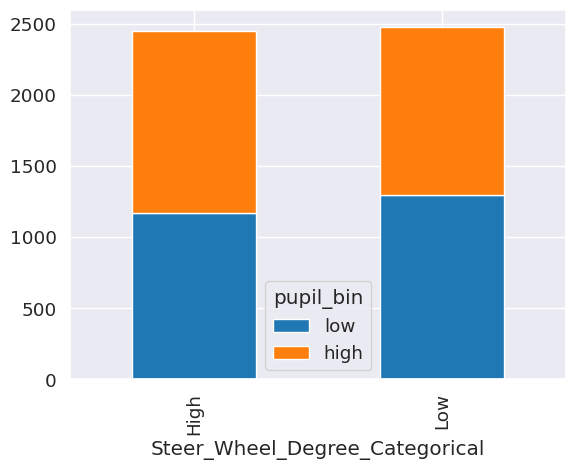

In [7]:
%matplotlib inline

motor_dfs_stacked = motor_dfs.copy()
motor_dfs_stacked = motor_dfs_stacked.groupby(['Steer_Wheel_Degree_Categorical', 'pupil_bin']).size().reset_index().pivot(columns='pupil_bin', index='Steer_Wheel_Degree_Categorical', values=0)
motor_dfs_stacked.plot(kind='bar', stacked=True)


In [66]:
from mne.time_frequency import tfr_morlet, psd_multitaper, psd_welch


# freq_range = np.logspace(*np.log10([4, 55]), num=15)
freq_range = np.linspace(4, 56, 28)
n_cycles = freq_range / 2.

#power_motor, itc_easy = tfr_morlet(motor_epochs, freqs=freq_range, n_cycles=n_cycles, use_fft=True, return_itc=True, n_jobs=-1)
low_motor = motor_epochs["Steer_Wheel_Degree_Categorical == 'Low'"]
high_motor = motor_epochs["Steer_Wheel_Degree_Categorical == 'High'"]
power_low_motor, itc_low = tfr_morlet(low_motor, freqs=freq_range, n_cycles=n_cycles, use_fft=True, return_itc=True, n_jobs=-1)
power_high_motor, itc_high = tfr_morlet(high_motor, freqs=freq_range, n_cycles=n_cycles, use_fft=True, return_itc=True, n_jobs=-1)



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done  64 out of  64 | elapsed:   44.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done  64 out of  64 | elapsed:   43.7s finished


No projector specified for this dataset. Please consider the method self.add_proj.


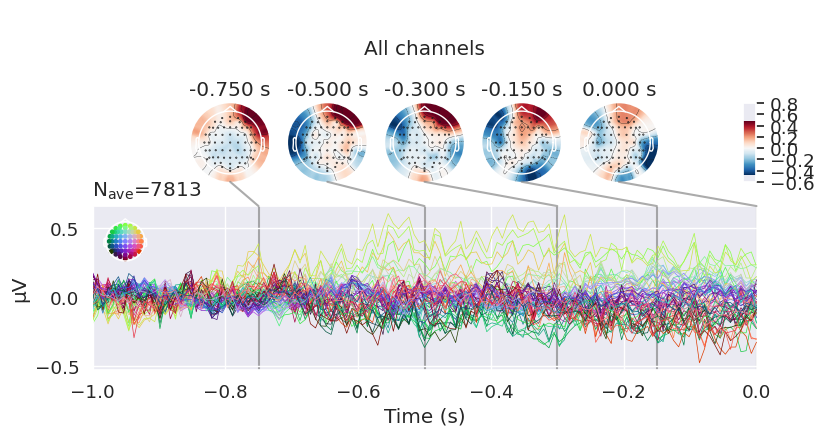

In [10]:

sel_chan = 49

# power_easy.plot_topo(baseline=(-0.5, -.2), mode='mean', title='Average power')
# power_easy.plot([sel_chan], baseline=(-3.2, -3), mode='mean', title=power_easy.ch_names[sel_chan])
# power_easy.plot([sel_chan], mode='mean', baseline=(-1,-.25), title=power_easy.ch_names[sel_chan])
# power_easy.plot([sel_chan], baseline=None, mode='mean', title=power_easy.ch_names[sel_chan])
rel_regions = {'premotor_regions': ['FC3', 'FC1', 'FCz', 'FC2', 'FC4'], 'dorsolateral_prefrontal': ['AF3', 'AFz', 'AF4'], 'intermediate_frontal': ['F3', 'F1', 'Fz', 'F2', 'F4']}
all_regions = sum(rel_regions.values(),[])
motor_epochs.average().plot_joint(times=[-.75, -.5, -.3, -.15,0], title='All channels');

Applying baseline correction (mode: mean)


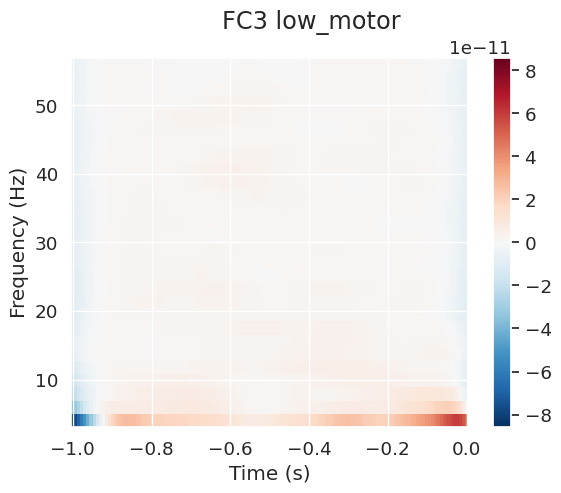

Applying baseline correction (mode: logratio)


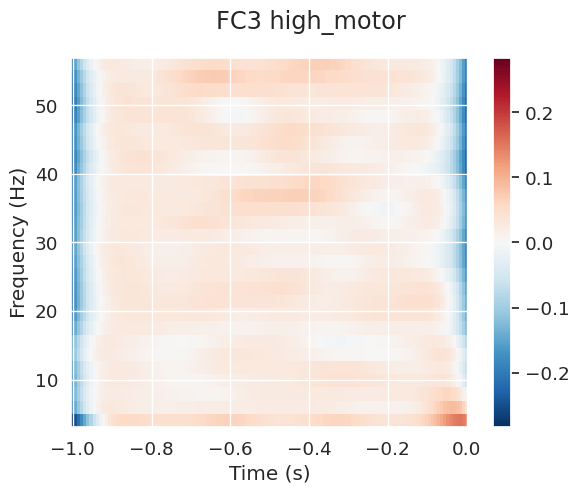

Applying baseline correction (mode: mean)


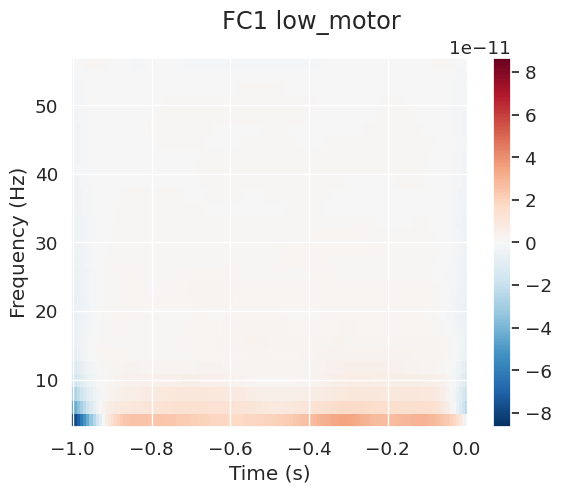

Applying baseline correction (mode: logratio)


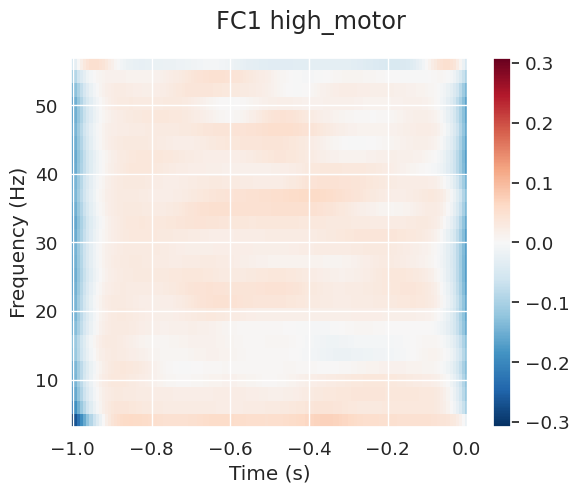

Applying baseline correction (mode: mean)


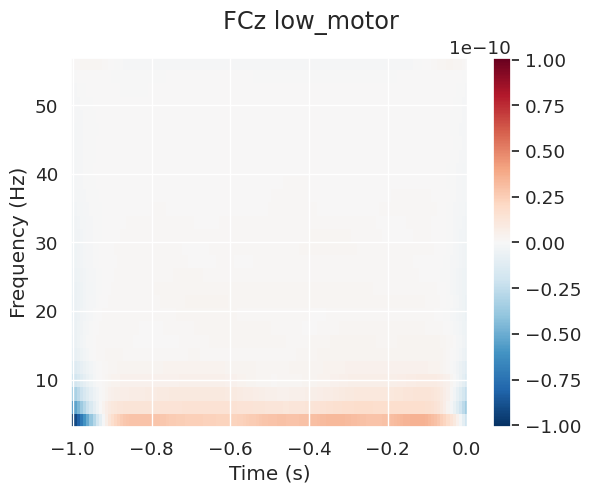

Applying baseline correction (mode: logratio)


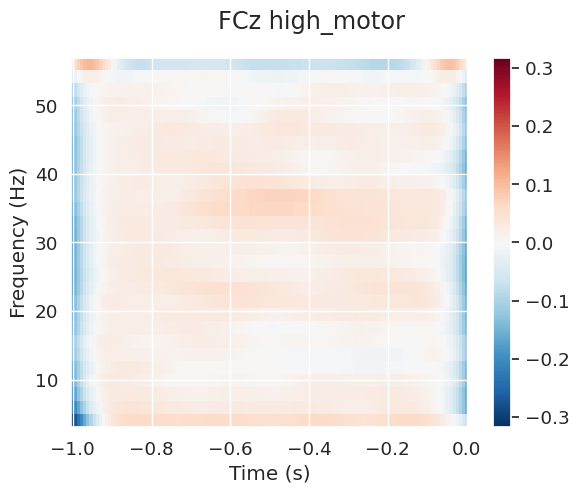

Applying baseline correction (mode: mean)


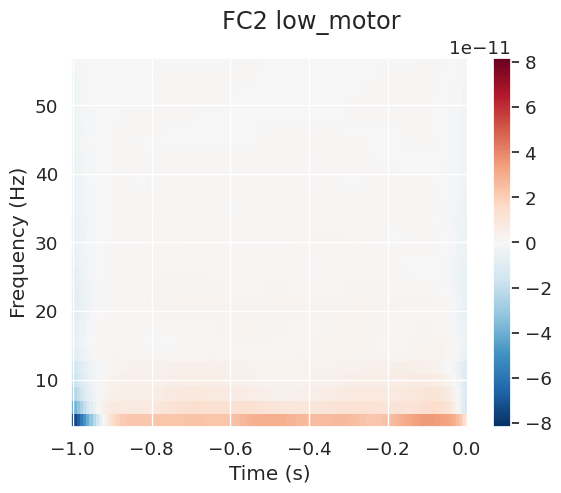

Applying baseline correction (mode: logratio)


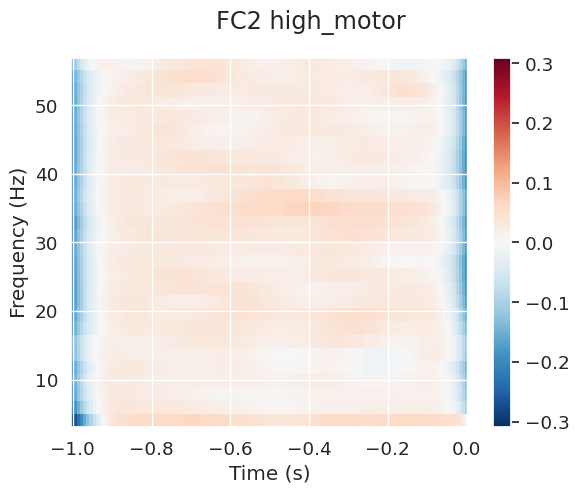

Applying baseline correction (mode: mean)


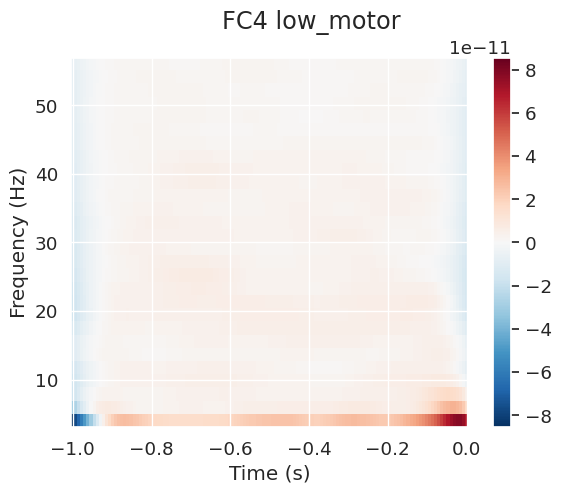

Applying baseline correction (mode: logratio)


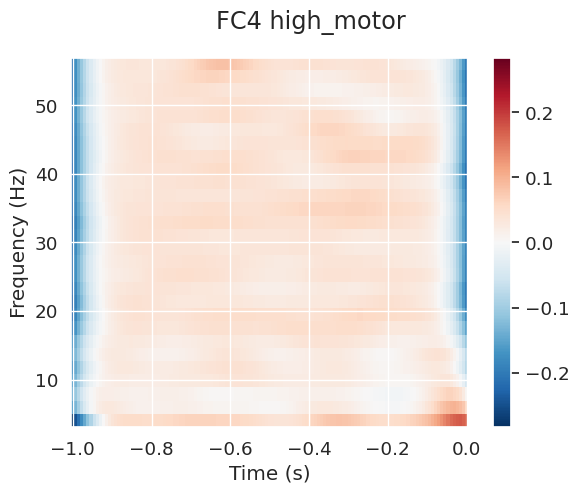

Applying baseline correction (mode: mean)


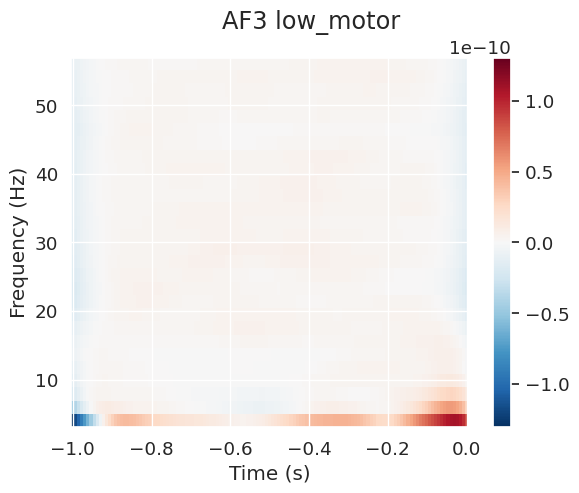

Applying baseline correction (mode: logratio)


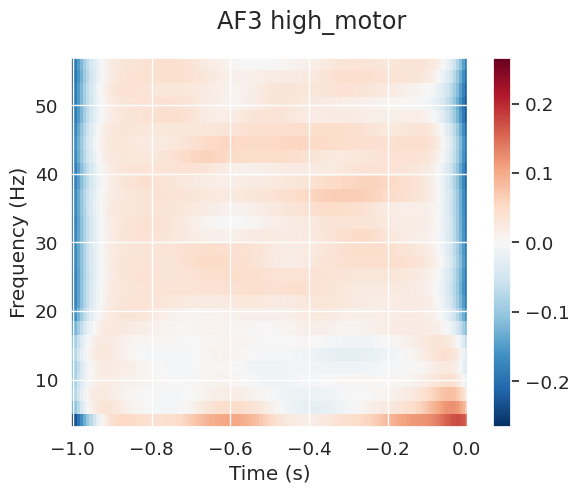

Applying baseline correction (mode: mean)


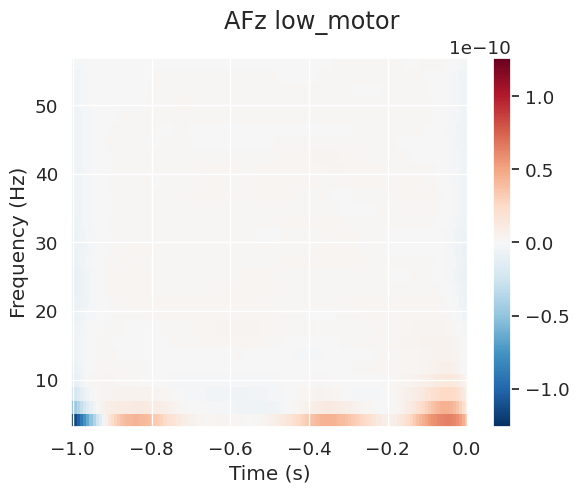

Applying baseline correction (mode: logratio)


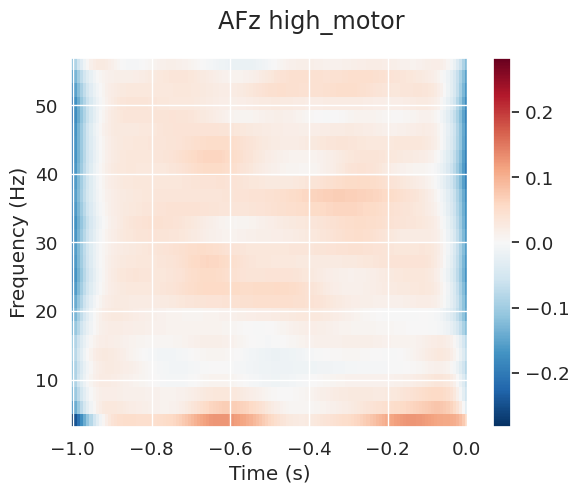

Applying baseline correction (mode: mean)


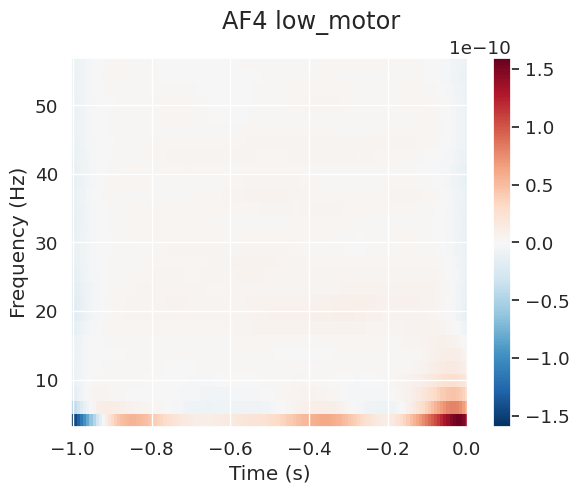

Applying baseline correction (mode: logratio)


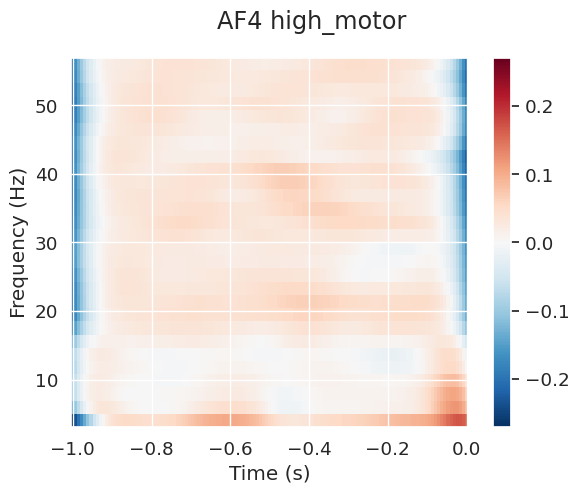

Applying baseline correction (mode: mean)


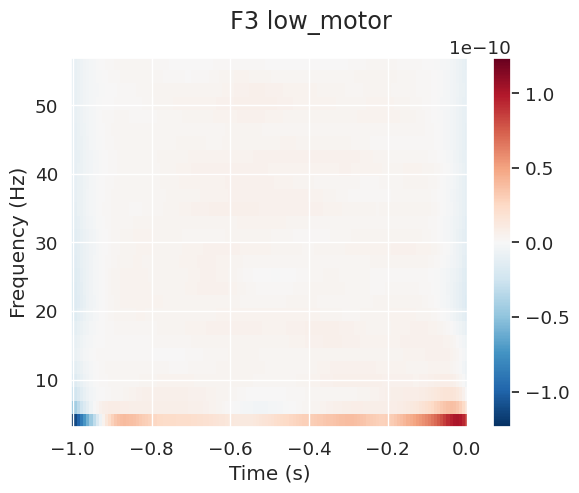

Applying baseline correction (mode: logratio)


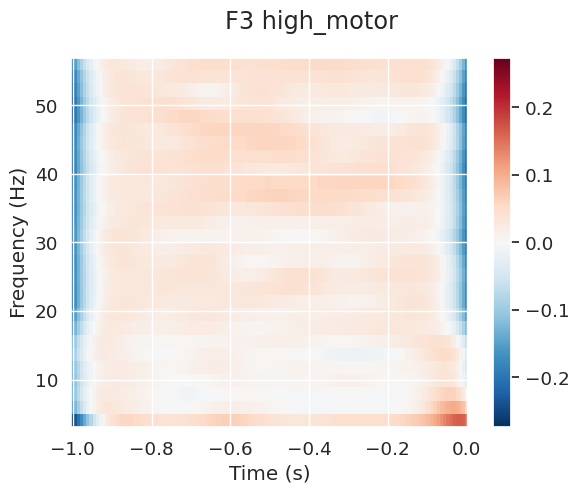

Applying baseline correction (mode: mean)


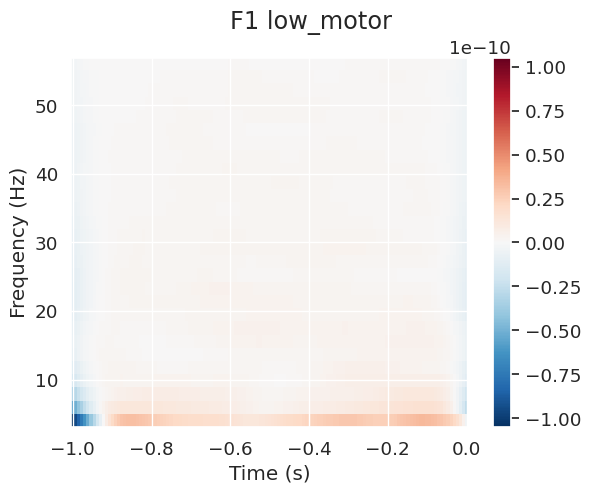

Applying baseline correction (mode: logratio)


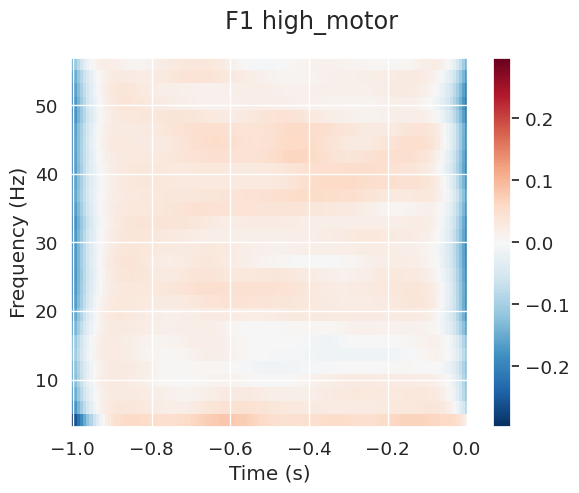

Applying baseline correction (mode: mean)


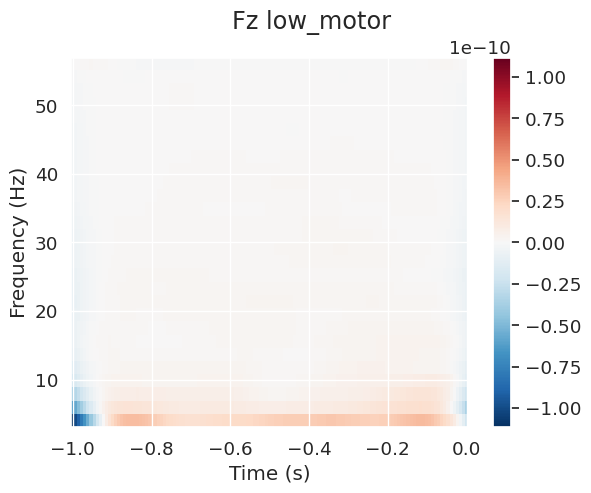

Applying baseline correction (mode: logratio)


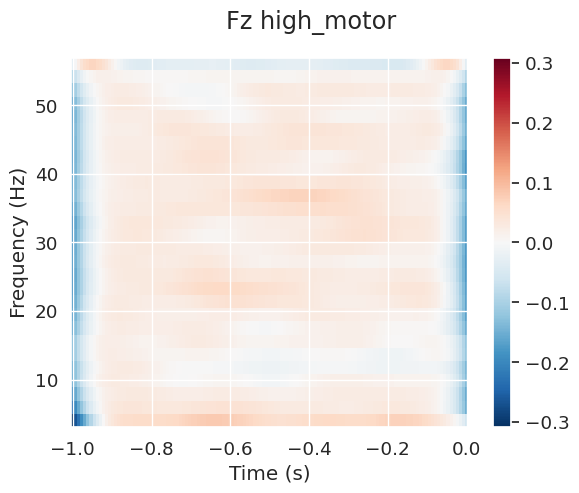

Applying baseline correction (mode: mean)


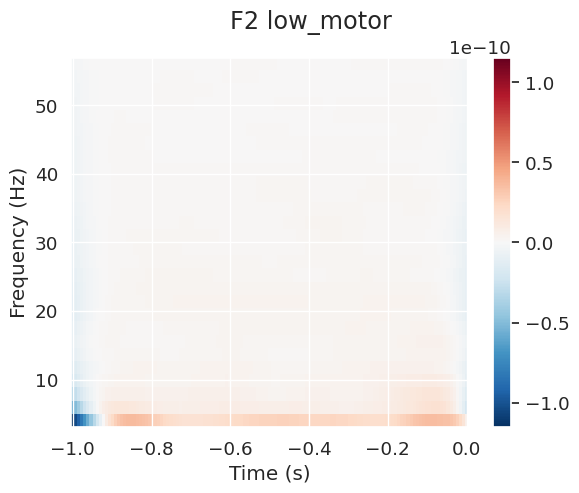

Applying baseline correction (mode: logratio)


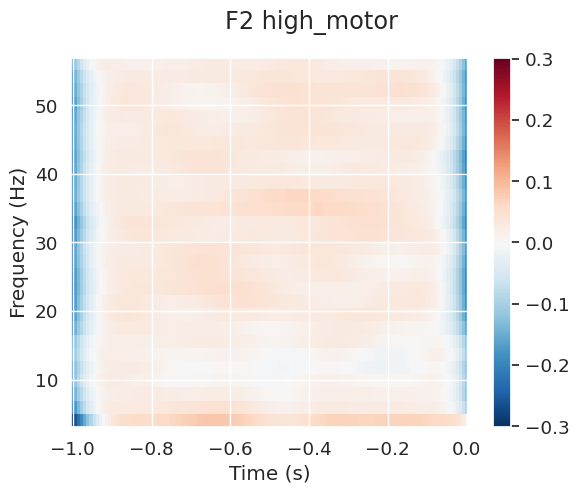

Applying baseline correction (mode: mean)


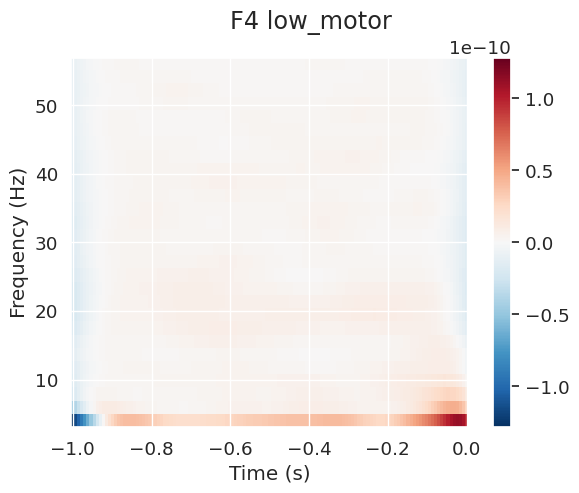

Applying baseline correction (mode: logratio)


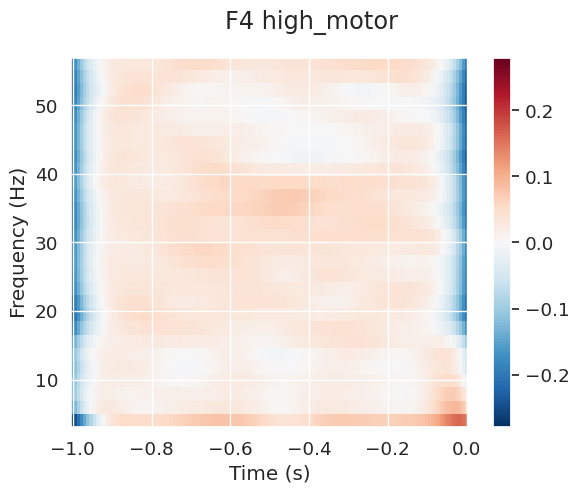

In [71]:
for r in rel_regions:
    all_channels = rel_regions[r]
    for each_chan in all_channels:
        sel_chan = power_easy.ch_names.index(each_chan)
        power_low_motor.plot([sel_chan], baseline=(-1,-.75), mode='logratio', title=power_easy.ch_names[sel_chan]+' low_motor')
        power_high_motor.plot([sel_chan], baseline=(-1,-.75), mode='logratio', title=power_easy.ch_names[sel_chan]+' high_motor')

## Evoked data by motor intensity

In [11]:
evokeds_iterable = dict()
evokeds = dict()

query = "Steer_Wheel_Degree_Categorical == '{}'"

for cond in motor_epochs.metadata['Steer_Wheel_Degree_Categorical'].unique():
    evokeds_iterable[str(cond)] = list(motor_epochs[query.format(cond)].iter_evoked())
    evokeds[str(cond)] = motor_epochs[query.format(cond)].average()


### Mean GFP

combining channels using "gfp"
combining channels using "gfp"


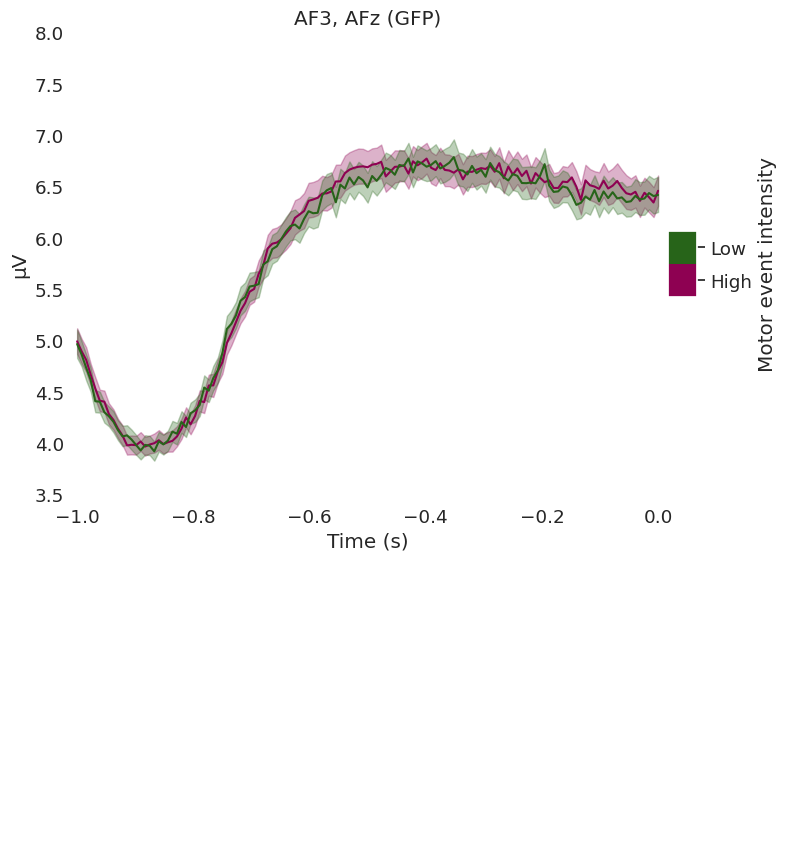

combining channels using "gfp"
combining channels using "gfp"


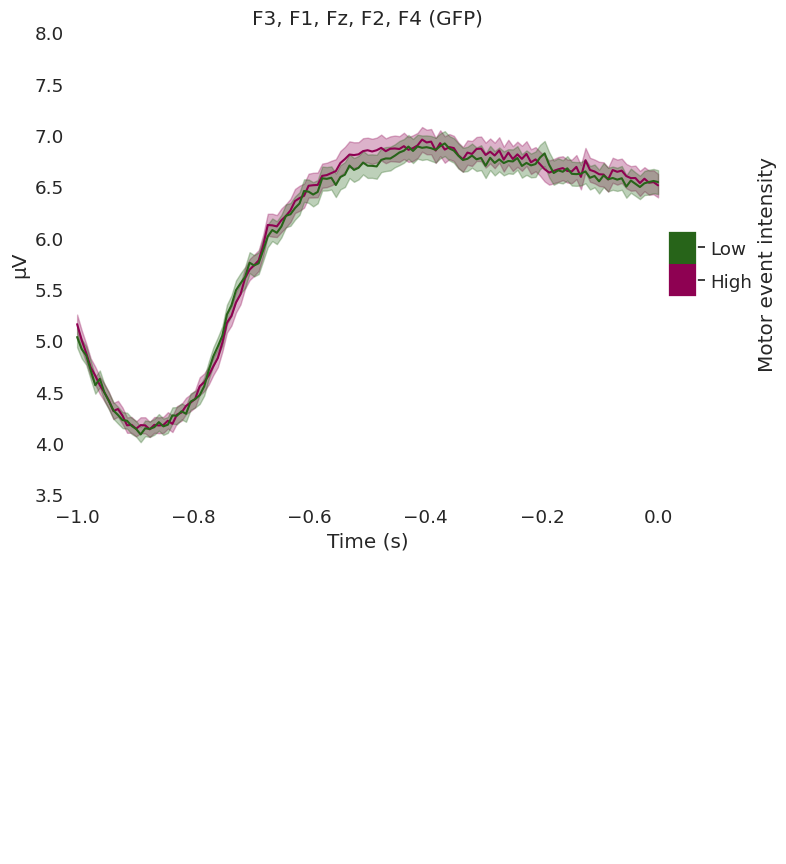

combining channels using "gfp"
combining channels using "gfp"


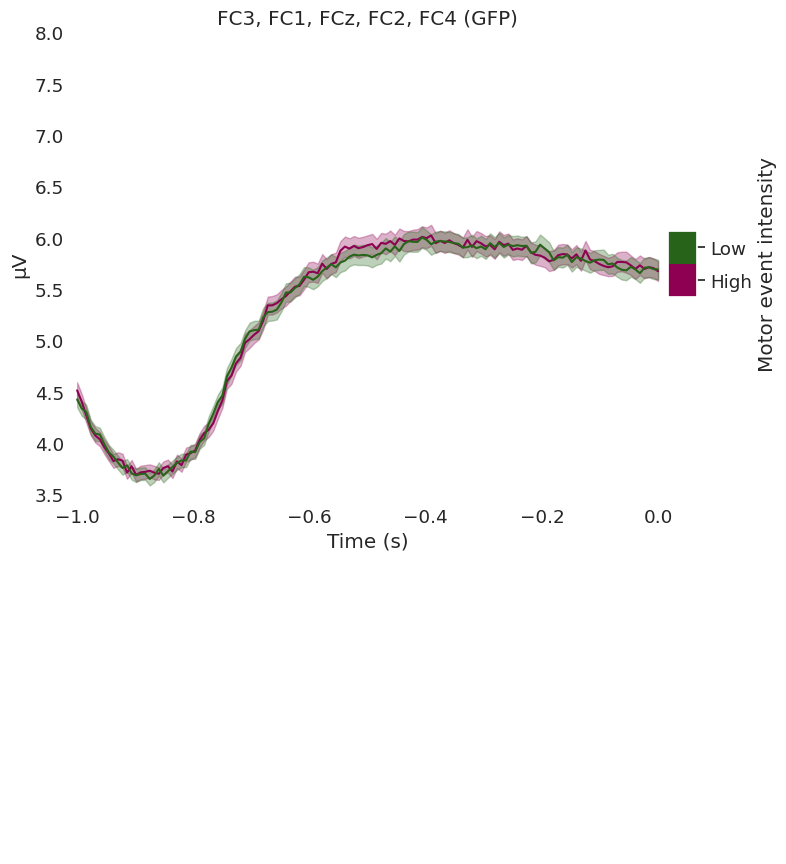

[<Figure size 800x600 with 2 Axes>]

In [25]:
mne.viz.plot_compare_evokeds(evokeds_iterable, cmap=('Motor event intensity', 'PiYG'),
                             picks=rel_regions['dorsolateral_prefrontal'],ylim=dict(eeg=[3.5,8]))
mne.viz.plot_compare_evokeds(evokeds_iterable, cmap=('Motor event intensity', 'PiYG'),
                             picks=rel_regions['intermediate_frontal'],combine='gfp',ylim=dict(eeg=[3.5,8]))
mne.viz.plot_compare_evokeds(evokeds_iterable, cmap=('Motor event intensity', 'PiYG'),
                             picks=rel_regions['premotor_regions'],combine='gfp',ylim=dict(eeg=[3.5,8]))

### Average response

combining channels using "mean"
combining channels using "mean"


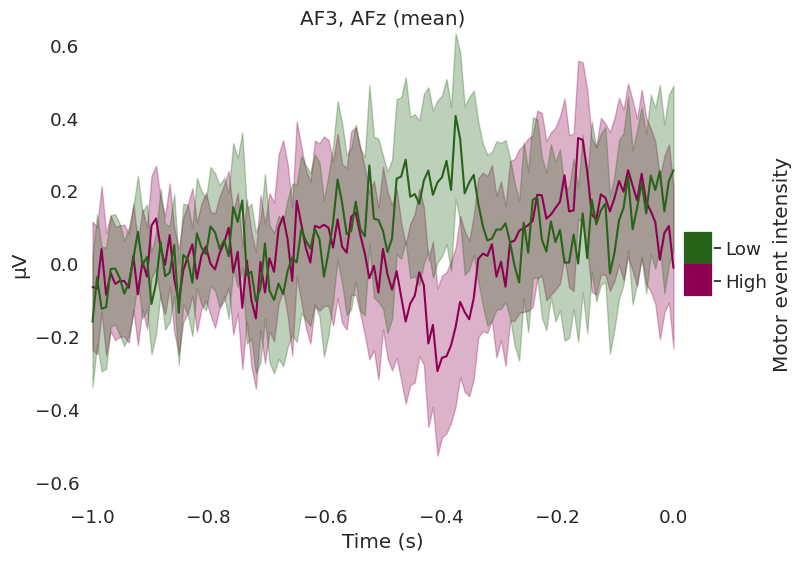

combining channels using "mean"
combining channels using "mean"


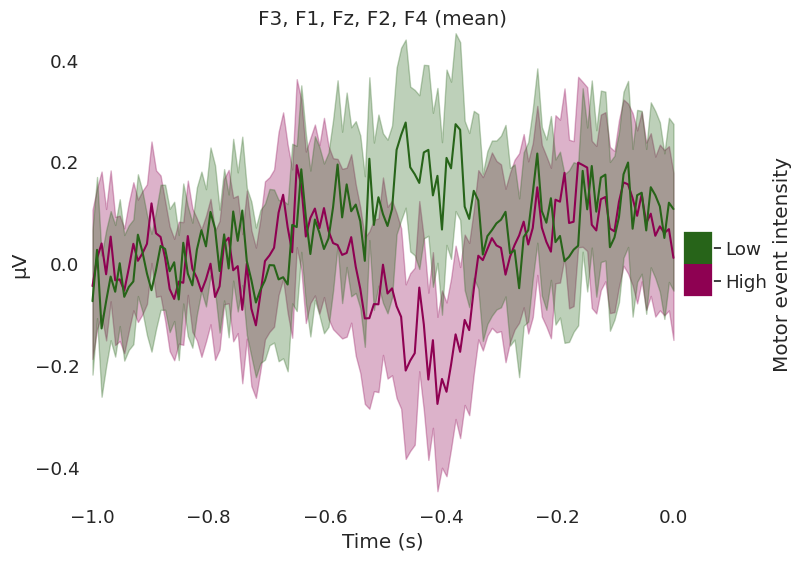

combining channels using "mean"
combining channels using "mean"


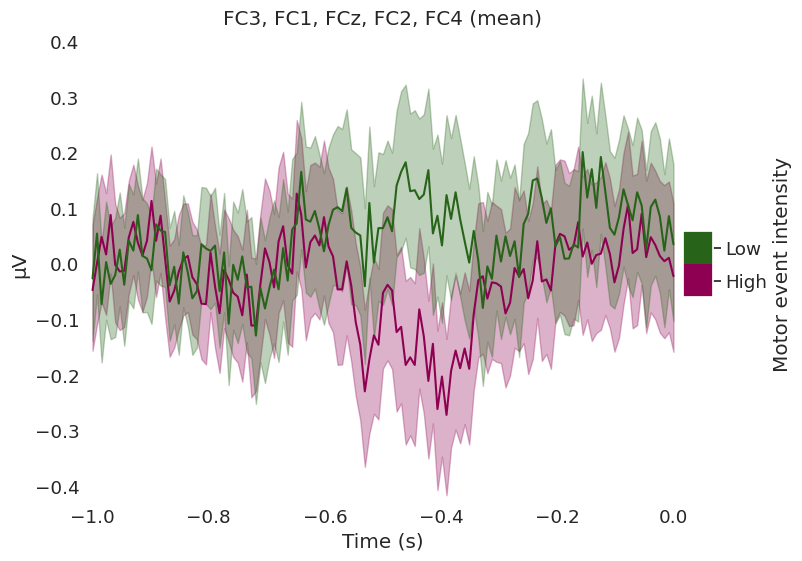

[<Figure size 800x600 with 2 Axes>]

In [16]:
mne.viz.plot_compare_evokeds(evokeds_iterable, cmap=('Motor event intensity', 'PiYG'),
                             picks=rel_regions['dorsolateral_prefrontal'],combine='mean')
mne.viz.plot_compare_evokeds(evokeds_iterable, cmap=('Motor event intensity', 'PiYG'),
                             picks=rel_regions['intermediate_frontal'],combine='mean')
mne.viz.plot_compare_evokeds(evokeds_iterable, cmap=('Motor event intensity', 'PiYG'),
                             picks=rel_regions['premotor_regions'],combine='mean')

# 11-07-22 Meeting

In [147]:
# seaborn
sns.set(font_scale=1.2)
sns.set_palette("tab10")
from mna.utils.batch_feature_extraction import clean_up_adadrive_trials

cols_of_interest = ["bpm", "density", "trial_duration", "trial_damage",
                                         "abs_sum_delta_steer_input", "abs_sum_delta_brake_input",
                                         "NSLR_count_Fixation", "NSLR_count_Saccade"]
experimental_cols = ['spoken_difficulty', 'trial_duration', 'density', 'trial_damage']
eye_cols = ['spoken_difficulty','Left Pupil Diameter', "NSLR_count_Fixation", "NSLR_count_Saccade",
            'NSLR_mean_duration_Fixation','NSLR_mean_duration_Saccade',
           'NSLR_first_onset_Fixation', 'NSLR_first_onset_Saccade']
ecg_cols = ['spoken_difficulty','density','bpm','sdnn', 'rmssd','pnn50'] # rmssd = parasympathetic
motor_cols = ['spoken_difficulty','density','abs_sum_delta_steer_input','abs_sum_delta_brake_input', 'abs_sum_delta_throttle_input'] 

def clean_up_trials(input_df):
    all_dfs_final = clean_up_adadrive_trials(input_df.copy())
    # damage change
    all_dfs_final = all_dfs_final.sort_values(by=['ppid', 'session', 'block'])
    # nan, outliers
    for col in cols_of_interest:
        all_dfs_final[col] = all_dfs_final[col].mask(all_dfs_final[col].sub(all_dfs_final[col].mean()).div(all_dfs_final[col].std()).abs().gt(2))
    all_dfs_final['abs_sum_delta_brake_input'] = all_dfs_final['abs_sum_delta_brake_input'].mask(all_dfs_final['abs_sum_delta_brake_input']>.1)

    all_dfs_final['NSLR_first_onset_Fixation'] = all_dfs_final['NSLR_first_onset_Fixation']-all_dfs_final['trial_start_time']
    all_dfs_final['NSLR_first_onset_Saccade'] = all_dfs_final['NSLR_first_onset_Saccade']-all_dfs_final['trial_start_time']
    all_dfs_final['bpm'] = all_dfs_final['bpm'].mask((all_dfs_final['bpm']<40) | (all_dfs_final['bpm']>150))
    all_dfs_final['throttle_over_brake'] = all_dfs_final.abs_sum_delta_throttle_input/all_dfs_final.abs_sum_delta_brake_input
    return all_dfs_final

motor_dfs = clean_up_trials(motor_dfs)
trial_dfs = clean_up_trials(trial_dfs)
# pupil bins
motor_dfs['pupil_bin'] = motor_dfs.groupby(['ppid'])['Left Pupil Diameter'].transform(
                     lambda x: pd.qcut(x, 2, labels=['low','high']))
trial_dfs['pupil_bin'] = trial_dfs.groupby(['ppid'])['Left Pupil Diameter'].transform(
                     lambda x: pd.qcut(x, 2, labels=['low','high']))

<AxesSubplot:xlabel='spoken_difficulty'>

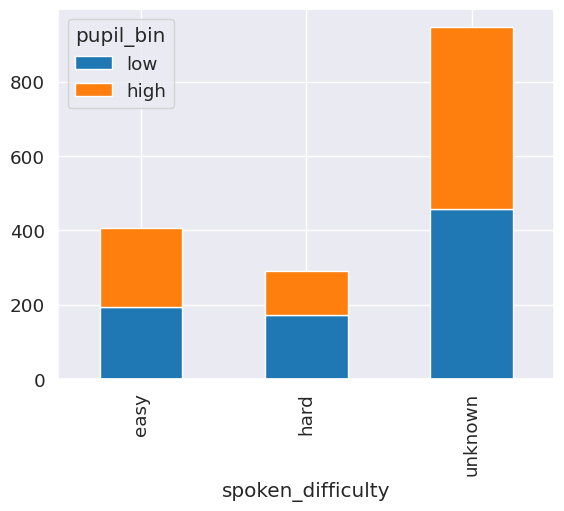

In [11]:
trial_dfs_stacked = trial_dfs.copy()
trial_dfs_stacked.spoken_difficulty = trial_dfs_stacked.spoken_difficulty.fillna('unknown')
trial_dfs_stacked = trial_dfs_stacked.groupby(['spoken_difficulty', 'pupil_bin']).size().reset_index().pivot(columns='pupil_bin', index='spoken_difficulty', values=0)
trial_dfs_stacked.plot(kind='bar', stacked=True)


trial_avg_low 18226.995461711842 diff motor-trial 1535.8153193710896 pval diff w/ motor 0.0004211208549380964
trial_avg_high 20725.231752573112 diff motor-trial -2019.6240742379305 pval diff w/ motor 1.708105321079078e-08
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

easy vs. hard: n=284 | p=1.94e-18 | n=409
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

easy vs. hard: n=124 | p=4.56e-02 | n=142
trial_avg_low 16977.043431384125 diff motor-trial 2427.2182908782015 pval diff w/ motor 1.5006814901341402e-09
trial_avg_high 18093.82080235426 diff motor-trial 1053.9166345320482 pval diff w/ motor 0.007371577669757718
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 

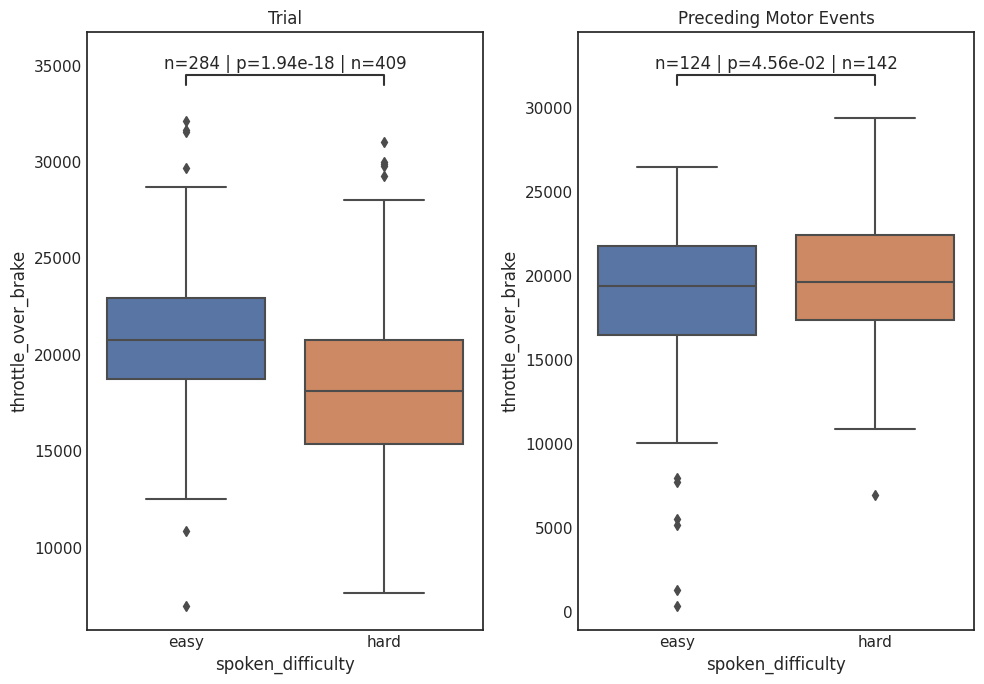

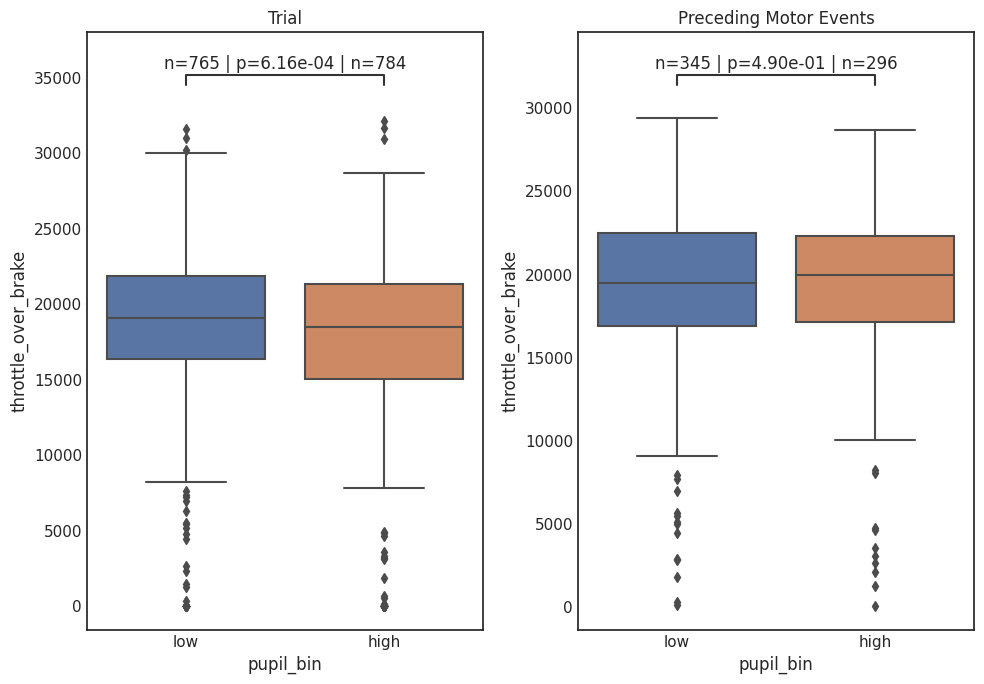

In [9]:
%matplotlib inline

sns.set(font_scale=1)
plt.style.use('seaborn-white')

def compare_motor_trial(trial_dfs, motor_dfs, y, x, order=None, ylabel=None, xlabel=None, plot_type='boxplot'):
    ax1_plotting_parameters = {
        'data':    trial_dfs,
        'x':       x,
        'y':       y,
        'order': order
    }
    ax2_plotting_parameters = {
        'data':    motor_dfs,
        'x':       x,
        'y':       y,
        'order': order
    }
    stat_results = defaultdict(list)
    formatted_pvalues = defaultdict(list)
    for idx,o in enumerate(order[1:]):
        relevant_axis = ax1_plotting_parameters
        this_df = relevant_axis['data']
        this_x = relevant_axis['x']
        this_y = relevant_axis['y']
        ax1_low = this_df.loc[(this_df[this_x] ==  order[idx-1]),  this_y].dropna().values
        ax1_high = this_df.loc[(this_df[this_x] ==  order[idx]),  this_y].dropna().values
        relevant_axis = ax2_plotting_parameters
        this_df = relevant_axis['data']
        this_x = relevant_axis['x']
        this_y = relevant_axis['y']
        ax2_low = this_df.loc[(this_df[this_x] ==  order[idx-1]),  this_y].dropna().values
        ax2_high = this_df.loc[(this_df[this_x] ==  order[idx]),  this_y].dropna().values
        print('trial_avg_low', np.nanmean(ax1_low), 'diff motor-trial', np.nanmean(ax2_low)-np.nanmean(ax1_low),'pval diff w/ motor', stats.ttest_ind(ax1_low, ax2_low, alternative="two-sided").pvalue)
        print('trial_avg_high', np.nanmean(ax1_high), 'diff motor-trial', np.nanmean(ax2_high)-np.nanmean(ax1_high),'pval diff w/ motor', stats.ttest_ind(ax1_high, ax2_high, alternative="two-sided").pvalue)
        stat_results['ax1'].append(stats.ttest_ind(ax1_low, ax1_high, alternative="two-sided").pvalue)
        stat_results['ax2'].append(stats.ttest_ind(ax2_low, ax2_high, alternative="two-sided").pvalue)
    formatted_pvalues['ax1'] = [f'n={len(ax1_low)} | p={pvalue:.2e} | n={len(ax1_high)}' for pvalue in stat_results['ax1']]
    formatted_pvalues['ax2'] = [f'n={len(ax2_low)} | p={pvalue:.2e} | n={len(ax2_high)}' for pvalue in stat_results['ax2']]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 7))
    if plot_type == 'boxplot':
        sns.boxplot(**ax1_plotting_parameters, ax=ax1)
        sns.boxplot(**ax2_plotting_parameters, ax=ax2)
    elif plot_type == 'stripplot':
        sns.stripplot(**ax1_plotting_parameters, ax=ax1)
        sns.stripplot(**ax2_plotting_parameters, ax=ax2)
    elif plot_type == 'barplot':
        sns.barplot(**ax1_plotting_parameters, ax=ax1)
        sns.barplot(**ax2_plotting_parameters, ax=ax2)
    ax1.set_title("Trial")
    ax2.set_title("Preceding Motor Events")
    
    # add stats
    annotator = Annotator(ax1, [(order[0],order[1])], **ax1_plotting_parameters)
    annotator.set_custom_annotations(formatted_pvalues['ax1'])
    annotator.annotate()
    #annotator.configure(text_format="simple")
    #annotator.set_pvalues_and_annotate(stat_results['ax1'])
    
    
    annotator = Annotator(ax2, [(order[0],order[1])], **ax2_plotting_parameters)
    annotator.set_custom_annotations(formatted_pvalues['ax2'])
    annotator.annotate()
    #annotator.configure(text_format="simple")
    #annotator.set_pvalues_and_annotate(stat_results['ax2'])

    fig.tight_layout()
    
    #g = sns.distplot(data=trial_dfs, y=y, x=x, kind="box", order=['easy','hard'], aspect=2)
    #g.set_axis_labels(f"{xlabel if xlabel else x}", f"{ylabel if ylabel else y}")
    #g.fig.suptitle('Trial', fontsize=20)
    
    #g = sns.distplot(data=motor_dfs, y=y, x=x, kind="box", order=['easy','hard'], aspect=2)
    #g.set_axis_labels(f"{xlabel if xlabel else x}", f"{ylabel if ylabel else y}")
    #g.fig.suptitle('Preceding Motor Events', fontsize=20)
    

compare_motor_trial(trial_dfs, motor_dfs[motor_dfs.throttle_over_brake>0], y='throttle_over_brake', x='spoken_difficulty', ylabel='Perceived difficulty', order=['easy','hard'])
compare_motor_trial(trial_dfs, motor_dfs[motor_dfs.throttle_over_brake>0], y='throttle_over_brake', x='pupil_bin', order=['low','high'])

## Eye tracking 

trial_avg_low 0.09280135698562612 diff motor-trial -0.018850704788333034 pval diff w/ motor 7.167705235023082e-06
trial_avg_high 0.09662062799543067 diff motor-trial -0.016830218238543568 pval diff w/ motor 0.00013462458789864854
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

easy vs. hard: n=280 | p=4.67e-01 | n=396
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

easy vs. hard: n=452 | p=1.12e-01 | n=551
trial_avg_low 0.09466519373396098 diff motor-trial -0.017938883170279293 pval diff w/ motor 2.2064696552669626e-09
trial_avg_high 0.09727822428610154 diff motor-trial -0.018125431951024132 pval diff w/ motor 2.2242264324803034e-11
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      *

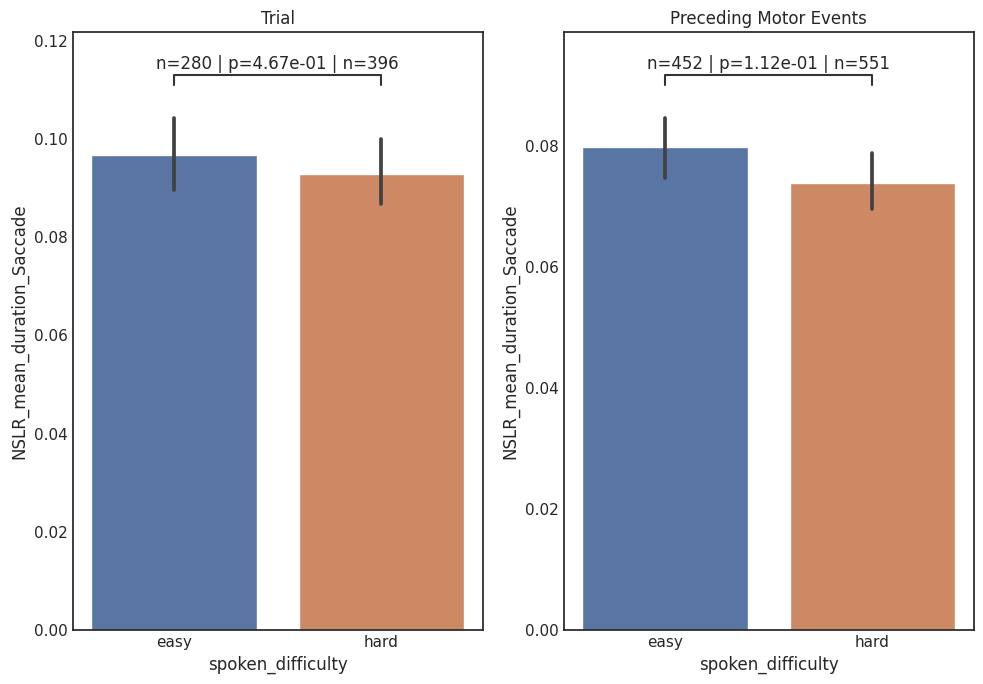

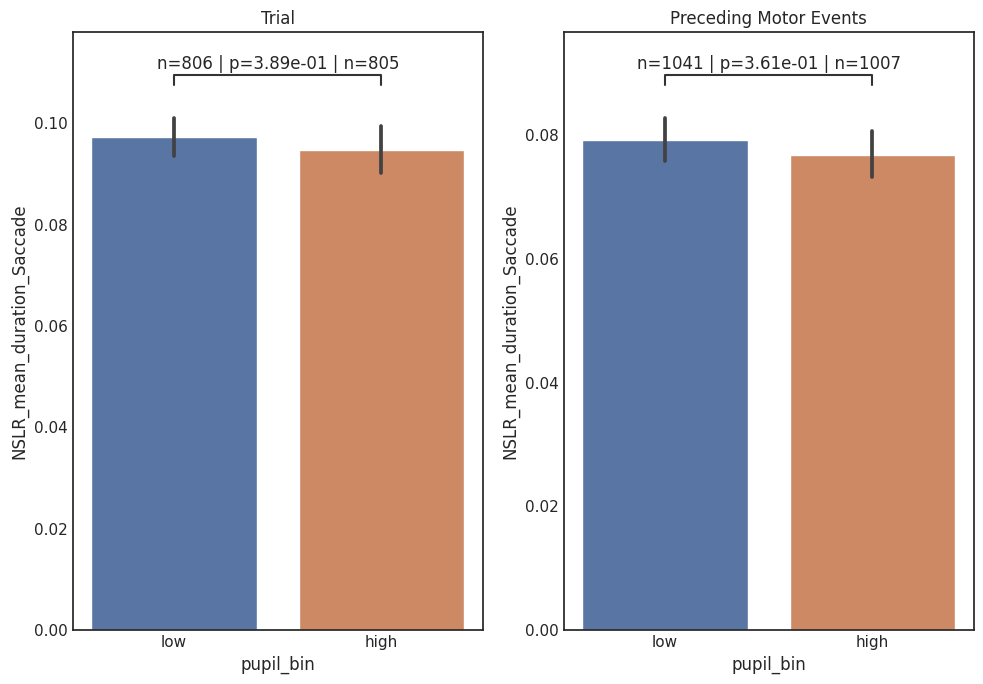

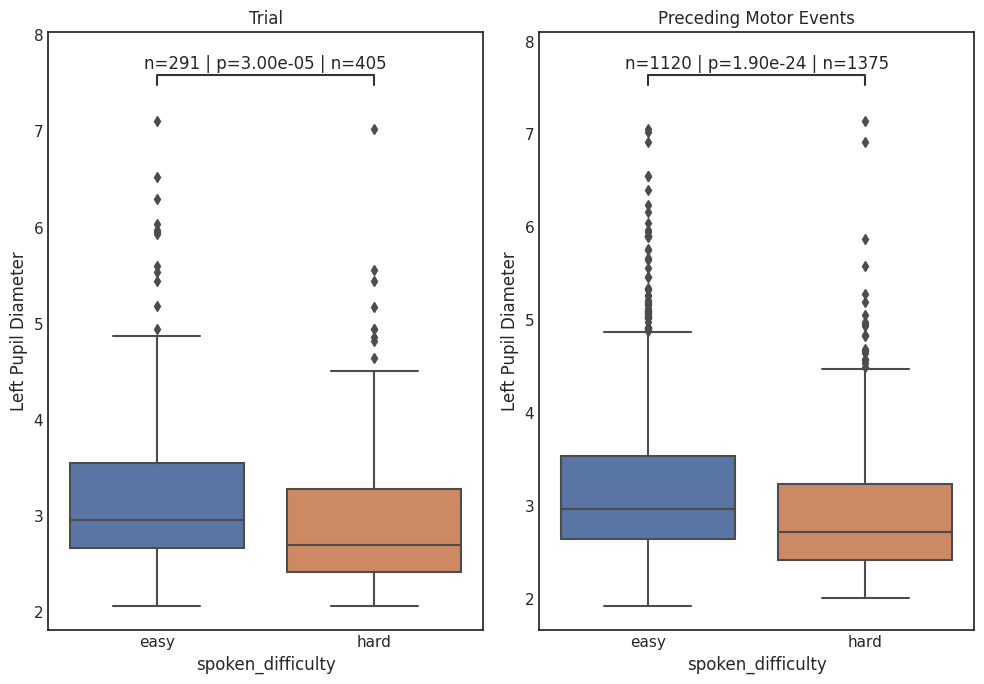

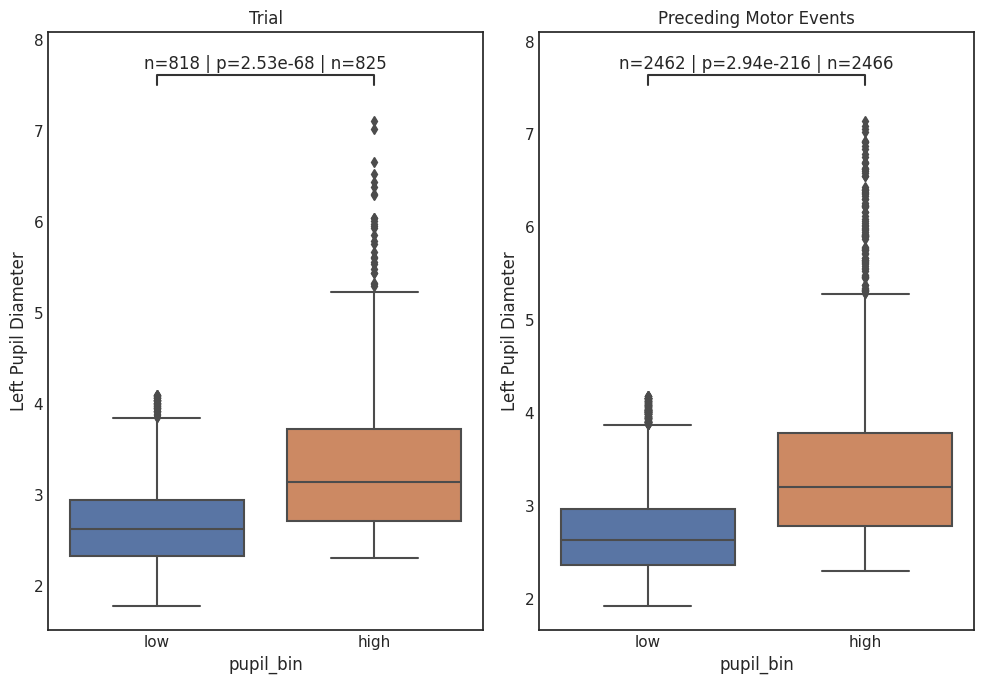

In [11]:
compare_motor_trial(trial_dfs, motor_dfs, y='NSLR_mean_duration_Saccade', x='spoken_difficulty', ylabel='Perceived difficulty', order=['easy','hard'], plot_type='barplot')
compare_motor_trial(trial_dfs, motor_dfs, y='NSLR_mean_duration_Saccade', x='pupil_bin', order=['low','high'], plot_type='barplot')

compare_motor_trial(trial_dfs, motor_dfs, y='Left Pupil Diameter', x='spoken_difficulty', ylabel='Perceived difficulty', order=['easy','hard'])
compare_motor_trial(trial_dfs, motor_dfs, y='Left Pupil Diameter', x='pupil_bin', order=['low','high'])

## EEG

trial_avg_low 0.09475437301781381 diff motor-trial 0.00842815012919508 pval diff w/ motor 0.033473954427147054
trial_avg_high 0.093654312313759 diff motor-trial 0.00550742919642408 pval diff w/ motor 0.08922656442346585
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

easy vs. hard: n=299 | p=7.72e-01 | n=414
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

easy vs. hard: n=1148 | p=1.02e-01 | n=1395
trial_avg_low 0.09939135376590402 diff motor-trial 0.0057267513563064865 pval diff w/ motor 0.1273617998745199
trial_avg_high 0.090920537427116 diff motor-trial 0.010172829802525457 pval diff w/ motor 0.001567800412941073
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <

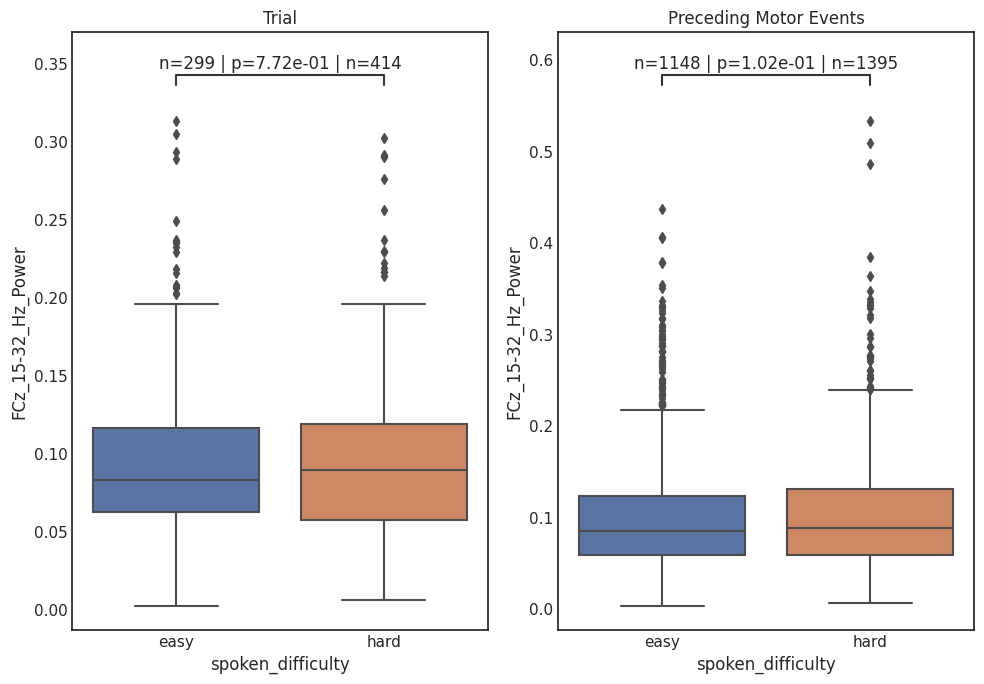

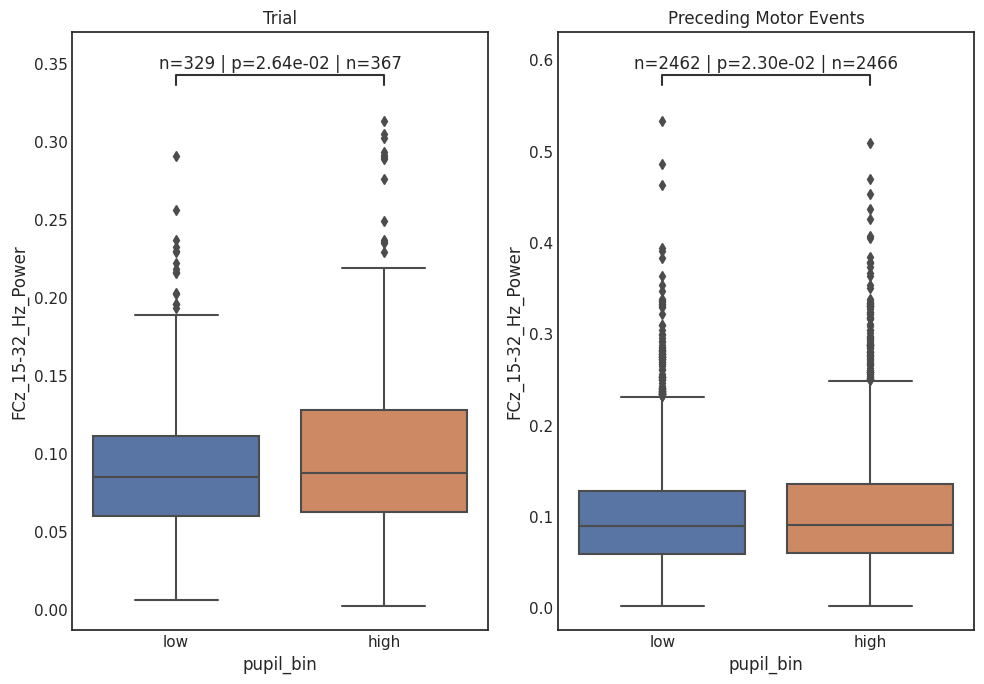

In [10]:
compare_motor_trial(trial_dfs, motor_dfs, y='FCz_15-32_Hz_Power', x='spoken_difficulty', ylabel='Perceived difficulty', order=['easy','hard'])
compare_motor_trial(trial_dfs, motor_dfs, y='FCz_15-32_Hz_Power', x='pupil_bin', order=['low','high'])

trial_avg_low 0.12129860058772464 diff motor-trial 0.004167034853675658 pval diff w/ motor 0.47890333469212254
trial_avg_high 0.117647285080786 diff motor-trial 0.004509168072424713 pval diff w/ motor 0.37928943290357775
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

easy vs. hard: n=299 | p=5.77e-01 | n=414
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

easy vs. hard: n=1148 | p=3.70e-01 | n=1395
trial_avg_low 0.1291947639001664 diff motor-trial -0.0035771941916381833 pval diff w/ motor 0.5372110374160071
trial_avg_high 0.11230288058158264 diff motor-trial 0.014657091911026848 pval diff w/ motor 0.003527765585852528
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < 

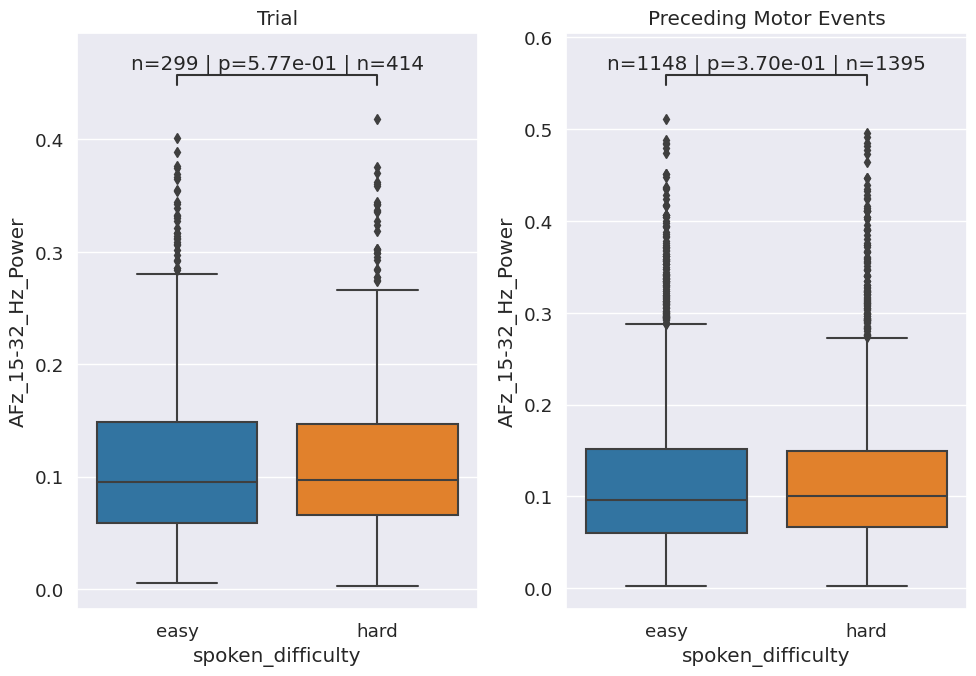

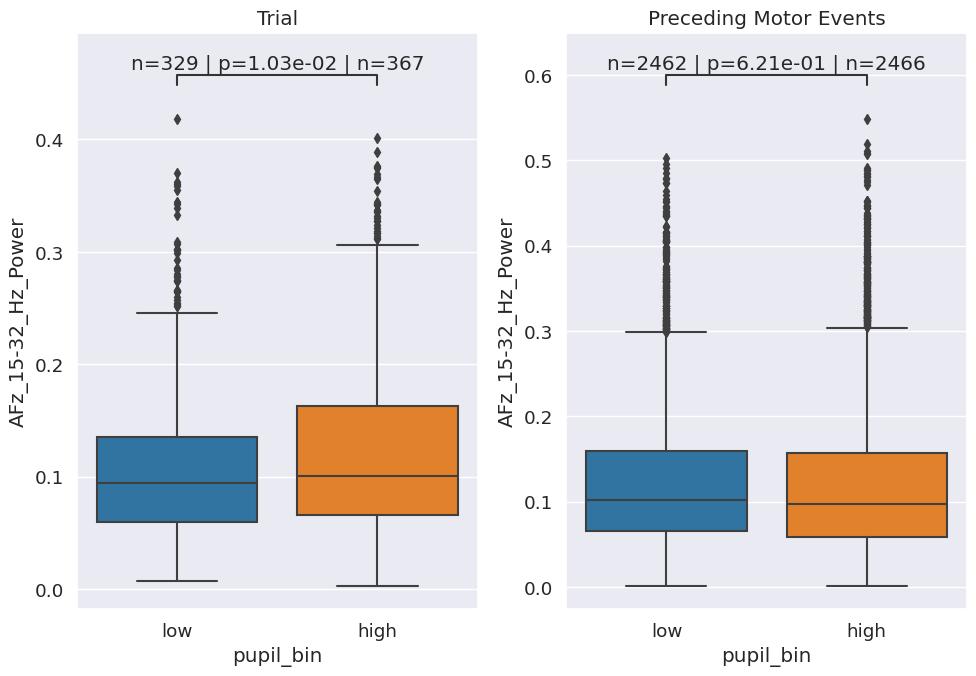

In [24]:
compare_motor_trial(trial_dfs, motor_dfs, y='AFz_15-32_Hz_Power', x='spoken_difficulty', ylabel='Perceived difficulty', order=['easy','hard'])
compare_motor_trial(trial_dfs, motor_dfs, y='AFz_15-32_Hz_Power', x='pupil_bin', order=['low','high'])

In [ ]:
from mne.time_frequency import tfr_morlet, psd_multitaper, psd_welch

epochs_easy = motor_epochs['easy']
epochs_hard = motor_epochs['hard']

#freq_range = np.logspace(*np.log10([4, 55]), num=15)
#freq_range = np.linspace(4, 56, 28)
#n_cycles = freq_range / 2.

#power_easy, itc_easy = tfr_morlet(epochs_easy, freqs=freq_range, n_cycles=n_cycles, use_fft=True, return_itc=True, n_jobs=1)
#power_hard, itc_hard = tfr_morlet(epochs_hard, freqs=freq_range, n_cycles=n_cycles, use_fft=True, return_itc=True, n_jobs=1)

In [ ]:
%matplotlib inline

sel_chan = power_easy.ch_names.index('FCz')
power_easy.plot([sel_chan], mode='mean', title=power_easy.ch_names[sel_chan])
power_hard.plot([sel_chan], mode='mean', title=power_hard.ch_names[sel_chan])
power_hard.plot_joint(baseline=(-1, -.75), mode='mean')

In [ ]:
%matplotlib qt
itc_easy.plot_topo(title='Inter-Trial coherence', vmin=0., vmax=1., cmap='Reds')

In [ ]:
from mne.viz import plot_evoked_topo
%matplotlib inline
colors = 'blue', 'red'
title = 'MNE sample data\nleft vs right (A/V combined)'
evokeds = [motor_epochs[name].average() for name in ('easy', 'hard')]
fig, ax = plt.subplots(figsize=(7, 4))
mne.viz.plot_compare_evokeds(evokeds, picks=['FC3','FC1','FCz'], colors=dict(easy=0, hard=1),
                             time_unit='ms', ci=.95, axes=ax)
times = evokeds[0].times
ax.fill_between(times,
                # transform values to microvolt
                upper_b[pick] * 1e6,
                lower_b[pick] * 1e6,
                color=['k'],
                alpha=0.2)

In [49]:
motor_dfs.shape
motor_epochs

<Epochs |  8374 events (all good), -1 - 0 sec, baseline off, ~527.6 MB, data loaded,
 'easy': 2373
 'hard': 2152
 'unknown': 3849>

## Fixation

### Condition split

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


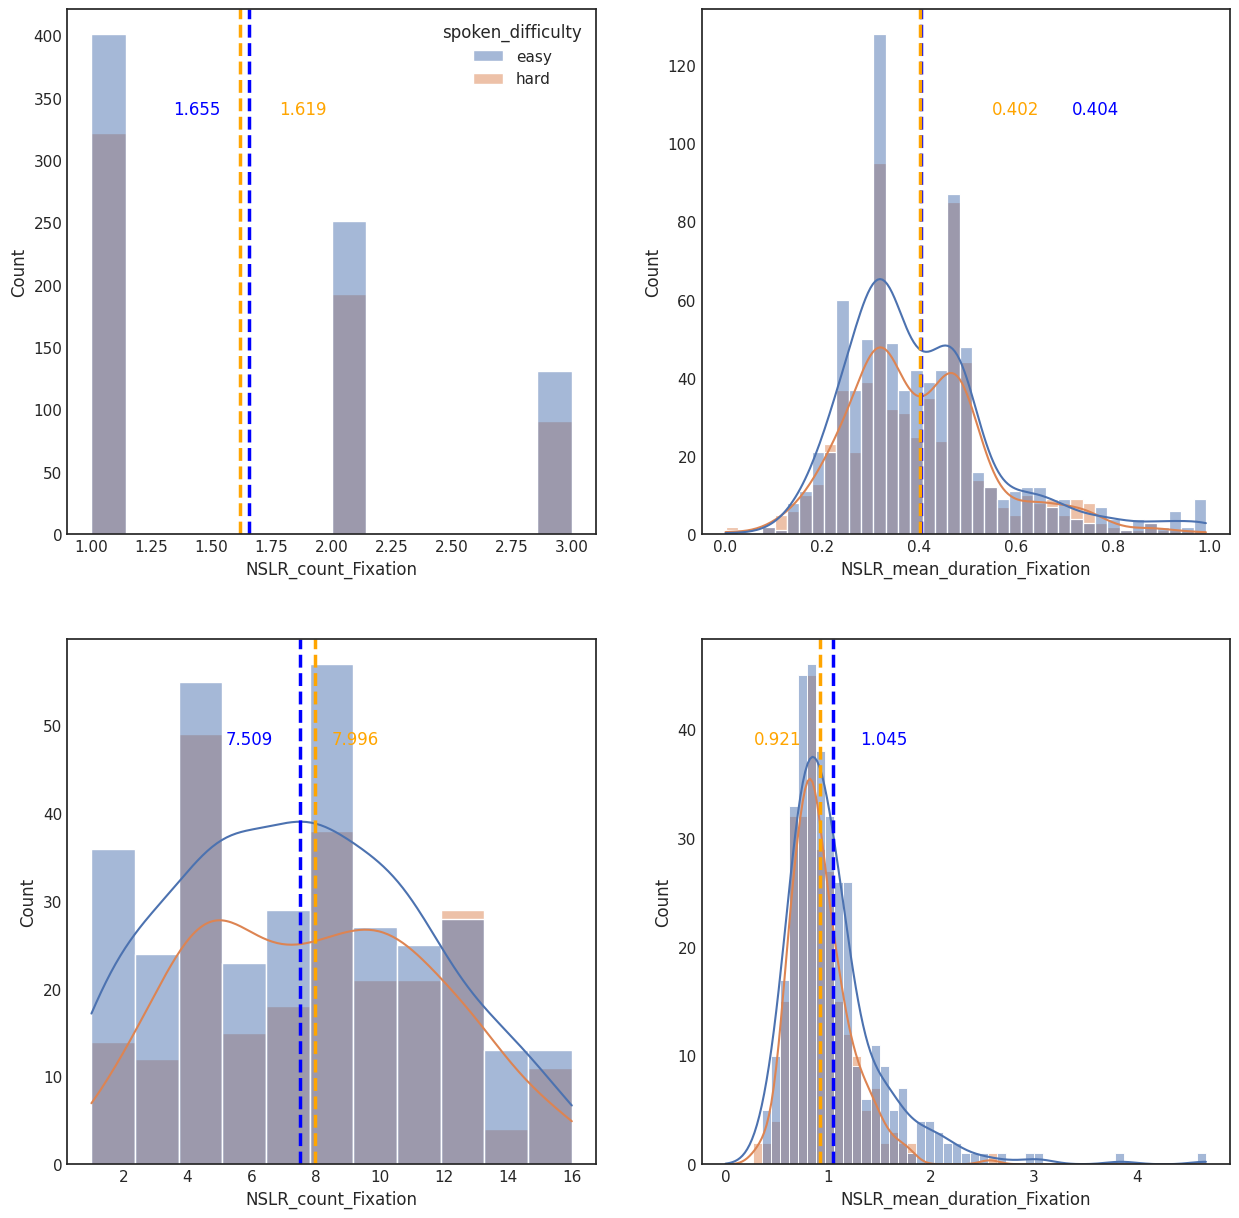

In [104]:
fig, axs = plt.subplots(2, 2, figsize=(15, 15))
left_measure = 'NSLR_count_Fixation'
right_measure = 'NSLR_mean_duration_Fixation'
hue='spoken_difficulty'
hue_order = ['easy','hard']
sns.histplot(data=motor_dfs, x=left_measure, kde=False, ax=axs[0, 0], hue=hue, hue_order=hue_order)
axs[0, 0].axvline(x=motor_dfs.loc[motor_dfs[hue]==hue_order[0],left_measure].mean(),
            color='blue',
            ls='--', 
            lw=2.5)
axs[0, 0].text(0.2,.8, round(motor_dfs.loc[motor_dfs[hue]==hue_order[0],left_measure].mean(),3), color='blue', fontsize = 12, transform=axs[0, 0].transAxes)
axs[0, 0].axvline(x=motor_dfs.loc[motor_dfs[hue]==hue_order[1],left_measure].mean(),
            color='orange',
            ls='--', 
            lw=2.5)
axs[0, 0].text(0.4,.8, round(motor_dfs.loc[motor_dfs[hue]==hue_order[1],left_measure].mean(),3), color='orange', fontsize = 12, transform=axs[0, 0].transAxes)

sns.histplot(data=motor_dfs, x=right_measure, legend=False, kde=True, ax=axs[0, 1], hue=hue, hue_order=hue_order)
axs[0, 1].axvline(x=motor_dfs.loc[motor_dfs[hue]==hue_order[0],right_measure].mean(),
            color='blue',
            ls='--', 
            lw=2.5)
axs[0, 1].text(1.9,.8, round(motor_dfs.loc[motor_dfs[hue]==hue_order[0],right_measure].mean(),3), color='blue', fontsize = 12, transform=axs[0, 0].transAxes)
axs[0, 1].axvline(x=motor_dfs.loc[motor_dfs[hue]==hue_order[1],right_measure].mean(),
            color='orange',
            ls='--', 
            lw=2.5)
axs[0, 1].text(1.75,.8, round(motor_dfs.loc[motor_dfs[hue]==hue_order[1],right_measure].mean(),3), color='orange', fontsize = 12, transform=axs[0, 0].transAxes)

sns.histplot(data=trial_dfs, x=left_measure, kde=True, legend=False, ax=axs[1, 0], hue=hue, hue_order=hue_order)
axs[1, 0].axvline(x=trial_dfs.loc[trial_dfs[hue]==hue_order[0],left_measure].mean(),
            color='blue',
            ls='--', 
            lw=2.5)
axs[1, 0].text(0.3,-.4, round(trial_dfs.loc[trial_dfs[hue]==hue_order[0],left_measure].mean(),3), color='blue', fontsize = 12, transform=axs[0, 0].transAxes)
axs[1, 0].axvline(x=trial_dfs.loc[trial_dfs[hue]==hue_order[1],left_measure].mean(),
            color='orange',
            ls='--', 
            lw=2.5)
axs[1, 0].text(0.5,-.4, round(trial_dfs.loc[trial_dfs[hue]==hue_order[1],left_measure].mean(),3), color='orange', fontsize = 12, transform=axs[0, 0].transAxes)

sns.histplot(data=trial_dfs, x=right_measure, kde=True, ax=axs[1, 1], hue=hue, hue_order=hue_order)
axs[1, 1].axvline(x=trial_dfs.loc[trial_dfs[hue]==hue_order[0],right_measure].mean(),
            color='blue',
            ls='--', 
            lw=2.5)
axs[1, 1].text(1.5,-.4, round(trial_dfs.loc[trial_dfs[hue]==hue_order[0],right_measure].mean(),3), color='blue', fontsize = 12, transform=axs[0, 0].transAxes)
axs[1, 1].axvline(x=trial_dfs.loc[trial_dfs[hue]==hue_order[1],right_measure].mean(),
            color='orange',
            ls='--', 
            lw=2.5)
axs[1, 1].text(1.3,-.4, round(trial_dfs.loc[trial_dfs[hue]==hue_order[1],right_measure].mean(),3), color='orange', fontsize = 12, transform=axs[0, 0].transAxes)


plt.legend() 
plt.show()

### Pupil split

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


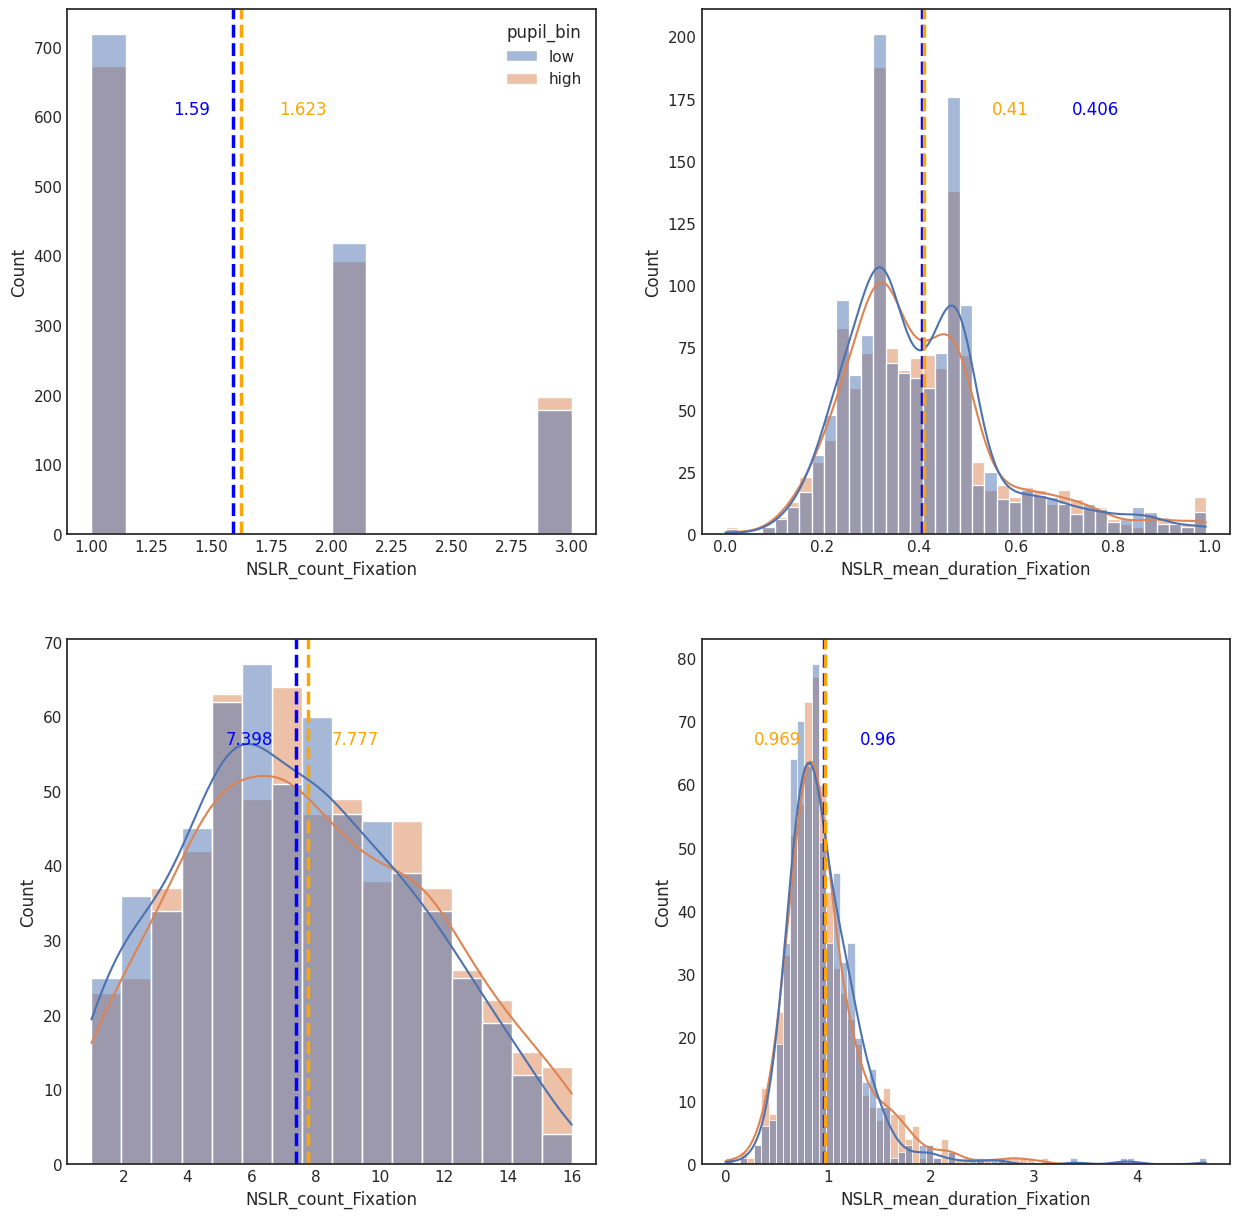

In [40]:
fig, axs = plt.subplots(2, 2, figsize=(15, 15))
left_measure = 'NSLR_count_Fixation'
right_measure = 'NSLR_mean_duration_Fixation'
hue='pupil_bin'
hue_order = ['low','high']
sns.histplot(data=motor_dfs, x=left_measure, kde=False, ax=axs[0, 0], hue=hue, hue_order=hue_order)
axs[0, 0].axvline(x=motor_dfs.loc[motor_dfs[hue]==hue_order[0],left_measure].mean(),
            color='blue',
            ls='--', 
            lw=2.5)
axs[0, 0].text(0.2,.8, round(motor_dfs.loc[motor_dfs[hue]==hue_order[0],left_measure].mean(),3), color='blue', fontsize = 12, transform=axs[0, 0].transAxes)
axs[0, 0].axvline(x=motor_dfs.loc[motor_dfs[hue]==hue_order[1],left_measure].mean(),
            color='orange',
            ls='--', 
            lw=2.5)
axs[0, 0].text(0.4,.8, round(motor_dfs.loc[motor_dfs[hue]==hue_order[1],left_measure].mean(),3), color='orange', fontsize = 12, transform=axs[0, 0].transAxes)

sns.histplot(data=motor_dfs, x=right_measure, legend=False, kde=True, ax=axs[0, 1], hue=hue, hue_order=hue_order)
axs[0, 1].axvline(x=motor_dfs.loc[motor_dfs[hue]==hue_order[0],right_measure].mean(),
            color='blue',
            ls='--', 
            lw=2.5)
axs[0, 1].text(1.9,.8, round(motor_dfs.loc[motor_dfs[hue]==hue_order[0],right_measure].mean(),3), color='blue', fontsize = 12, transform=axs[0, 0].transAxes)
axs[0, 1].axvline(x=motor_dfs.loc[motor_dfs[hue]==hue_order[1],right_measure].mean(),
            color='orange',
            ls='--', 
            lw=2.5)
axs[0, 1].text(1.75,.8, round(motor_dfs.loc[motor_dfs[hue]==hue_order[1],right_measure].mean(),3), color='orange', fontsize = 12, transform=axs[0, 0].transAxes)

sns.histplot(data=trial_dfs, x=left_measure, kde=True, legend=False, ax=axs[1, 0], hue=hue, hue_order=hue_order)
axs[1, 0].axvline(x=trial_dfs.loc[trial_dfs[hue]==hue_order[0],left_measure].mean(),
            color='blue',
            ls='--', 
            lw=2.5)
axs[1, 0].text(0.3,-.4, round(trial_dfs.loc[trial_dfs[hue]==hue_order[0],left_measure].mean(),3), color='blue', fontsize = 12, transform=axs[0, 0].transAxes)
axs[1, 0].axvline(x=trial_dfs.loc[trial_dfs[hue]==hue_order[1],left_measure].mean(),
            color='orange',
            ls='--', 
            lw=2.5)
axs[1, 0].text(0.5,-.4, round(trial_dfs.loc[trial_dfs[hue]==hue_order[1],left_measure].mean(),3), color='orange', fontsize = 12, transform=axs[0, 0].transAxes)

sns.histplot(data=trial_dfs, x=right_measure, kde=True, ax=axs[1, 1], hue=hue, hue_order=hue_order)
axs[1, 1].axvline(x=trial_dfs.loc[trial_dfs[hue]==hue_order[0],right_measure].mean(),
            color='blue',
            ls='--', 
            lw=2.5)
axs[1, 1].text(1.5,-.4, round(trial_dfs.loc[trial_dfs[hue]==hue_order[0],right_measure].mean(),3), color='blue', fontsize = 12, transform=axs[0, 0].transAxes)
axs[1, 1].axvline(x=trial_dfs.loc[trial_dfs[hue]==hue_order[1],right_measure].mean(),
            color='orange',
            ls='--', 
            lw=2.5)
axs[1, 1].text(1.3,-.4, round(trial_dfs.loc[trial_dfs[hue]==hue_order[1],right_measure].mean(),3), color='orange', fontsize = 12, transform=axs[0, 0].transAxes)


plt.legend() 
plt.show()

## Saccades

### Condition

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


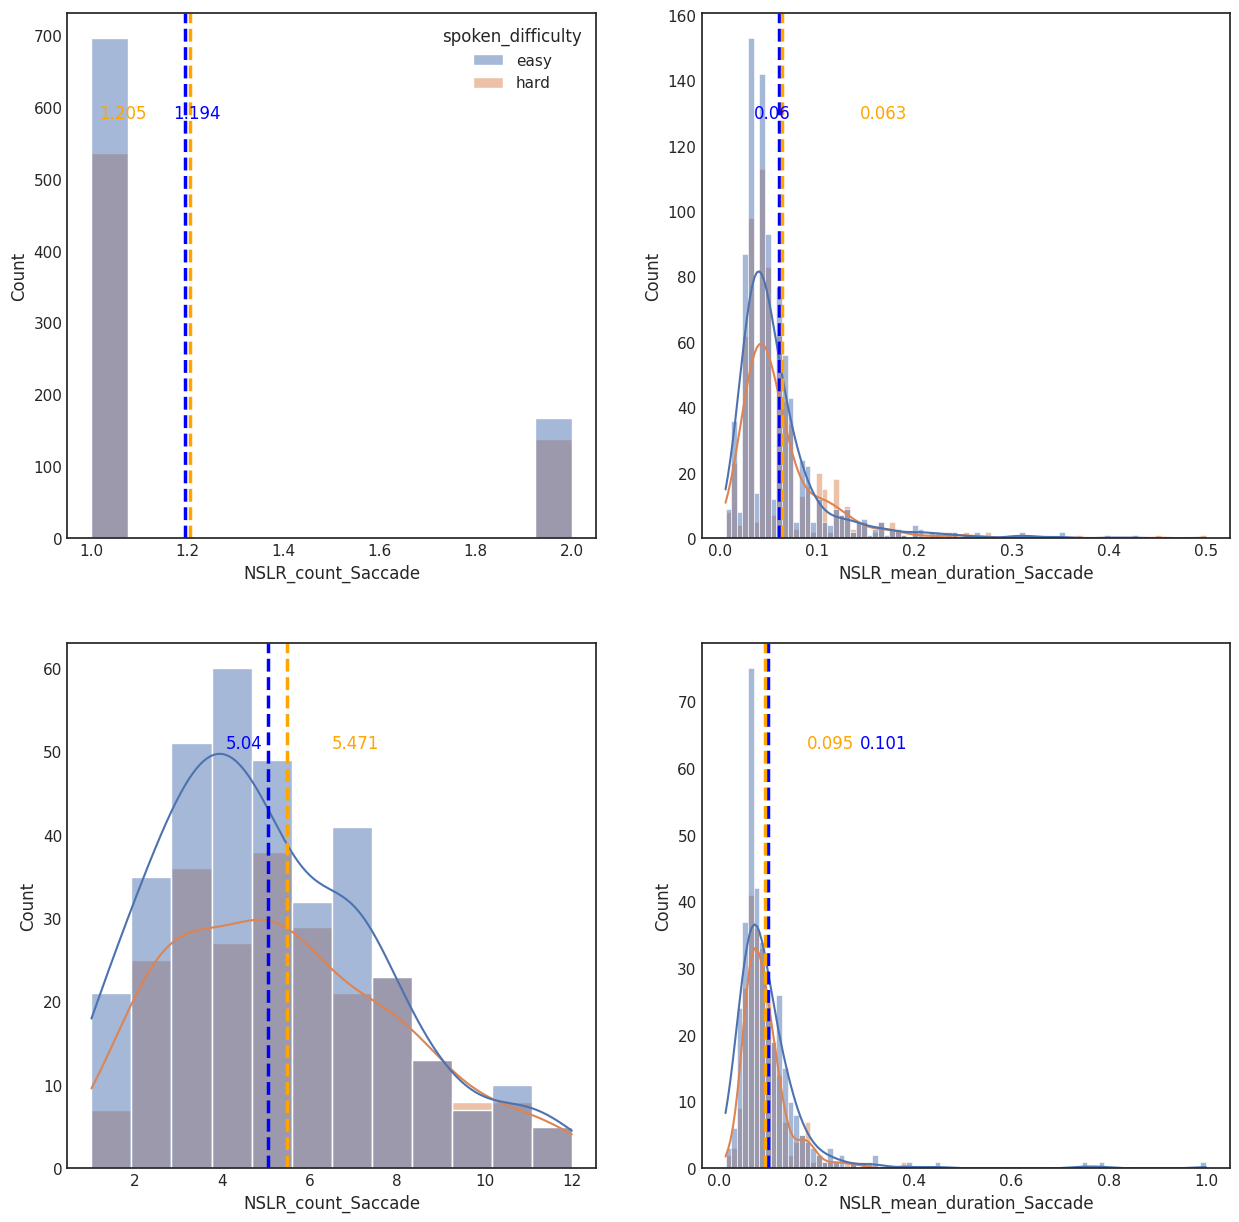

In [41]:
fig, axs = plt.subplots(2, 2, figsize=(15, 15))
left_measure = 'NSLR_count_Saccade'
right_measure = 'NSLR_mean_duration_Saccade'
hue='spoken_difficulty'
hue_order = ['easy','hard']
sns.histplot(data=motor_dfs, x=left_measure, kde=False, ax=axs[0, 0], hue=hue, hue_order=hue_order)
axs[0, 0].axvline(x=motor_dfs.loc[motor_dfs[hue]==hue_order[0],left_measure].mean(),
            color='blue',
            ls='--', 
            lw=2.5)
axs[0, 0].text(0.2,.8, round(motor_dfs.loc[motor_dfs[hue]==hue_order[0],left_measure].mean(),3), color='blue', fontsize = 12, transform=axs[0, 0].transAxes)
axs[0, 0].axvline(x=motor_dfs.loc[motor_dfs[hue]==hue_order[1],left_measure].mean(),
            color='orange',
            ls='--', 
            lw=2.5)
axs[0, 0].text(0.06,.8, round(motor_dfs.loc[motor_dfs[hue]==hue_order[1],left_measure].mean(),3), color='orange', fontsize = 12, transform=axs[0, 0].transAxes)

sns.histplot(data=motor_dfs, x=right_measure, legend=False, kde=True, ax=axs[0, 1], hue=hue, hue_order=hue_order)
axs[0, 1].axvline(x=motor_dfs.loc[motor_dfs[hue]==hue_order[0],right_measure].mean(),
            color='blue',
            ls='--', 
            lw=2.5)
axs[0, 1].text(1.3,.8, round(motor_dfs.loc[motor_dfs[hue]==hue_order[0],right_measure].mean(),3), color='blue', fontsize = 12, transform=axs[0, 0].transAxes)
axs[0, 1].axvline(x=motor_dfs.loc[motor_dfs[hue]==hue_order[1],right_measure].mean(),
            color='orange',
            ls='--', 
            lw=2.5)
axs[0, 1].text(1.5,.8, round(motor_dfs.loc[motor_dfs[hue]==hue_order[1],right_measure].mean(),3), color='orange', fontsize = 12, transform=axs[0, 0].transAxes)

sns.histplot(data=trial_dfs, x=left_measure, kde=True, legend=False, ax=axs[1, 0], hue=hue, hue_order=hue_order)
axs[1, 0].axvline(x=trial_dfs.loc[trial_dfs[hue]==hue_order[0],left_measure].mean(),
            color='blue',
            ls='--', 
            lw=2.5)
axs[1, 0].text(0.3,-.4, round(trial_dfs.loc[trial_dfs[hue]==hue_order[0],left_measure].mean(),3), color='blue', fontsize = 12, transform=axs[0, 0].transAxes)
axs[1, 0].axvline(x=trial_dfs.loc[trial_dfs[hue]==hue_order[1],left_measure].mean(),
            color='orange',
            ls='--', 
            lw=2.5)
axs[1, 0].text(0.5,-.4, round(trial_dfs.loc[trial_dfs[hue]==hue_order[1],left_measure].mean(),3), color='orange', fontsize = 12, transform=axs[0, 0].transAxes)

sns.histplot(data=trial_dfs, x=right_measure, kde=True, ax=axs[1, 1], hue=hue, hue_order=hue_order)
axs[1, 1].axvline(x=trial_dfs.loc[trial_dfs[hue]==hue_order[0],right_measure].mean(),
            color='blue',
            ls='--', 
            lw=2.5)
axs[1, 1].text(1.5,-.4, round(trial_dfs.loc[trial_dfs[hue]==hue_order[0],right_measure].mean(),3), color='blue', fontsize = 12, transform=axs[0, 0].transAxes)
axs[1, 1].axvline(x=trial_dfs.loc[trial_dfs[hue]==hue_order[1],right_measure].mean(),
            color='orange',
            ls='--', 
            lw=2.5)
axs[1, 1].text(1.4,-.4, round(trial_dfs.loc[trial_dfs[hue]==hue_order[1],right_measure].mean(),3), color='orange', fontsize = 12, transform=axs[0, 0].transAxes)


plt.legend() 
plt.show()

### Pupil

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


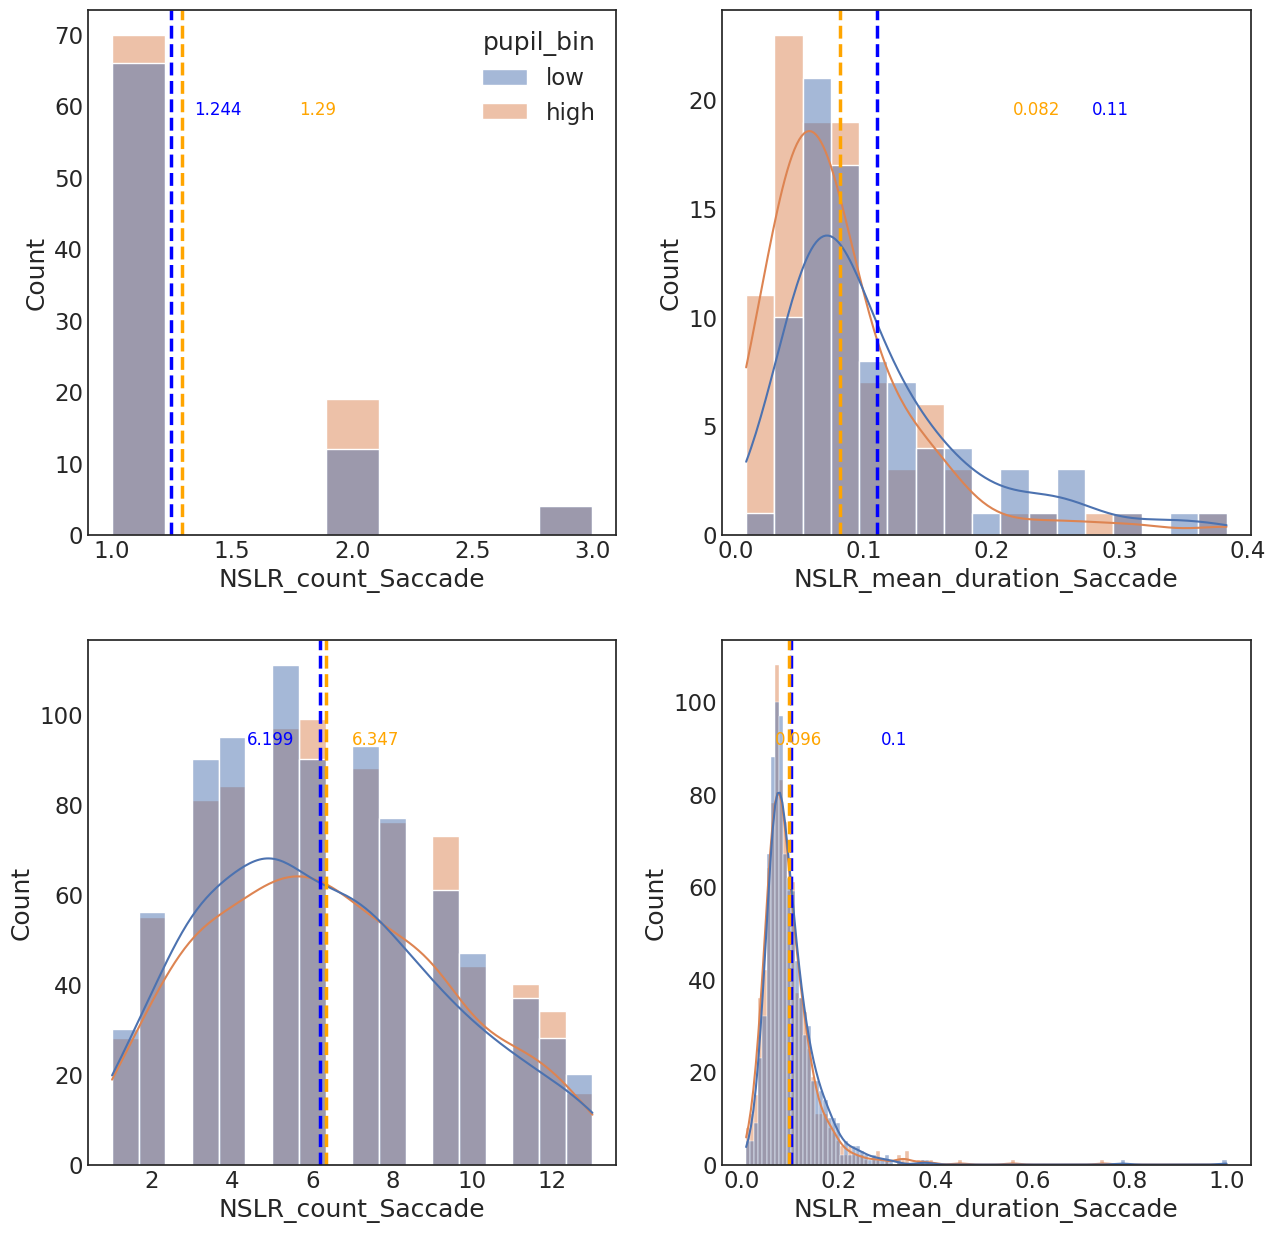

In [49]:
fig, axs = plt.subplots(2, 2, figsize=(15, 15))
left_measure = 'NSLR_count_Saccade'
right_measure = 'NSLR_mean_duration_Saccade'
hue='pupil_bin'
hue_order = ['low','high']
sns.histplot(data=motor_dfs, x=left_measure, kde=False, ax=axs[0, 0], hue=hue, hue_order=hue_order)
axs[0, 0].axvline(x=motor_dfs.loc[motor_dfs[hue]==hue_order[0],left_measure].mean(),
            color='blue',
            ls='--', 
            lw=2.5)
axs[0, 0].text(0.2,.8, round(motor_dfs.loc[motor_dfs[hue]==hue_order[0],left_measure].mean(),3), color='blue', fontsize = 12, transform=axs[0, 0].transAxes)
axs[0, 0].axvline(x=motor_dfs.loc[motor_dfs[hue]==hue_order[1],left_measure].mean(),
            color='orange',
            ls='--', 
            lw=2.5)
axs[0, 0].text(0.4,.8, round(motor_dfs.loc[motor_dfs[hue]==hue_order[1],left_measure].mean(),3), color='orange', fontsize = 12, transform=axs[0, 0].transAxes)

sns.histplot(data=motor_dfs, x=right_measure, legend=False, kde=True, ax=axs[0, 1], hue=hue, hue_order=hue_order)
axs[0, 1].axvline(x=motor_dfs.loc[motor_dfs[hue]==hue_order[0],right_measure].mean(),
            color='blue',
            ls='--', 
            lw=2.5)
axs[0, 1].text(1.9,.8, round(motor_dfs.loc[motor_dfs[hue]==hue_order[0],right_measure].mean(),3), color='blue', fontsize = 12, transform=axs[0, 0].transAxes)
axs[0, 1].axvline(x=motor_dfs.loc[motor_dfs[hue]==hue_order[1],right_measure].mean(),
            color='orange',
            ls='--', 
            lw=2.5)
axs[0, 1].text(1.75,.8, round(motor_dfs.loc[motor_dfs[hue]==hue_order[1],right_measure].mean(),3), color='orange', fontsize = 12, transform=axs[0, 0].transAxes)

sns.histplot(data=trial_dfs, x=left_measure, kde=True, legend=False, ax=axs[1, 0], hue=hue, hue_order=hue_order)
axs[1, 0].axvline(x=trial_dfs.loc[trial_dfs[hue]==hue_order[0],left_measure].mean(),
            color='blue',
            ls='--', 
            lw=2.5)
axs[1, 0].text(0.3,-.4, round(trial_dfs.loc[trial_dfs[hue]==hue_order[0],left_measure].mean(),3), color='blue', fontsize = 12, transform=axs[0, 0].transAxes)
axs[1, 0].axvline(x=trial_dfs.loc[trial_dfs[hue]==hue_order[1],left_measure].mean(),
            color='orange',
            ls='--', 
            lw=2.5)
axs[1, 0].text(0.5,-.4, round(trial_dfs.loc[trial_dfs[hue]==hue_order[1],left_measure].mean(),3), color='orange', fontsize = 12, transform=axs[0, 0].transAxes)

sns.histplot(data=trial_dfs, x=right_measure, kde=True, ax=axs[1, 1], hue=hue, hue_order=hue_order)
axs[1, 1].axvline(x=trial_dfs.loc[trial_dfs[hue]==hue_order[0],right_measure].mean(),
            color='blue',
            ls='--', 
            lw=2.5)
axs[1, 1].text(1.5,-.4, round(trial_dfs.loc[trial_dfs[hue]==hue_order[0],right_measure].mean(),3), color='blue', fontsize = 12, transform=axs[0, 0].transAxes)
axs[1, 1].axvline(x=trial_dfs.loc[trial_dfs[hue]==hue_order[1],right_measure].mean(),
            color='orange',
            ls='--', 
            lw=2.5)
axs[1, 1].text(1.3,-.4, round(trial_dfs.loc[trial_dfs[hue]==hue_order[1],right_measure].mean(),3), color='orange', fontsize = 12, transform=axs[0, 0].transAxes)


plt.legend() 
plt.show()

## PMC Alpha Activity

### Condition

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


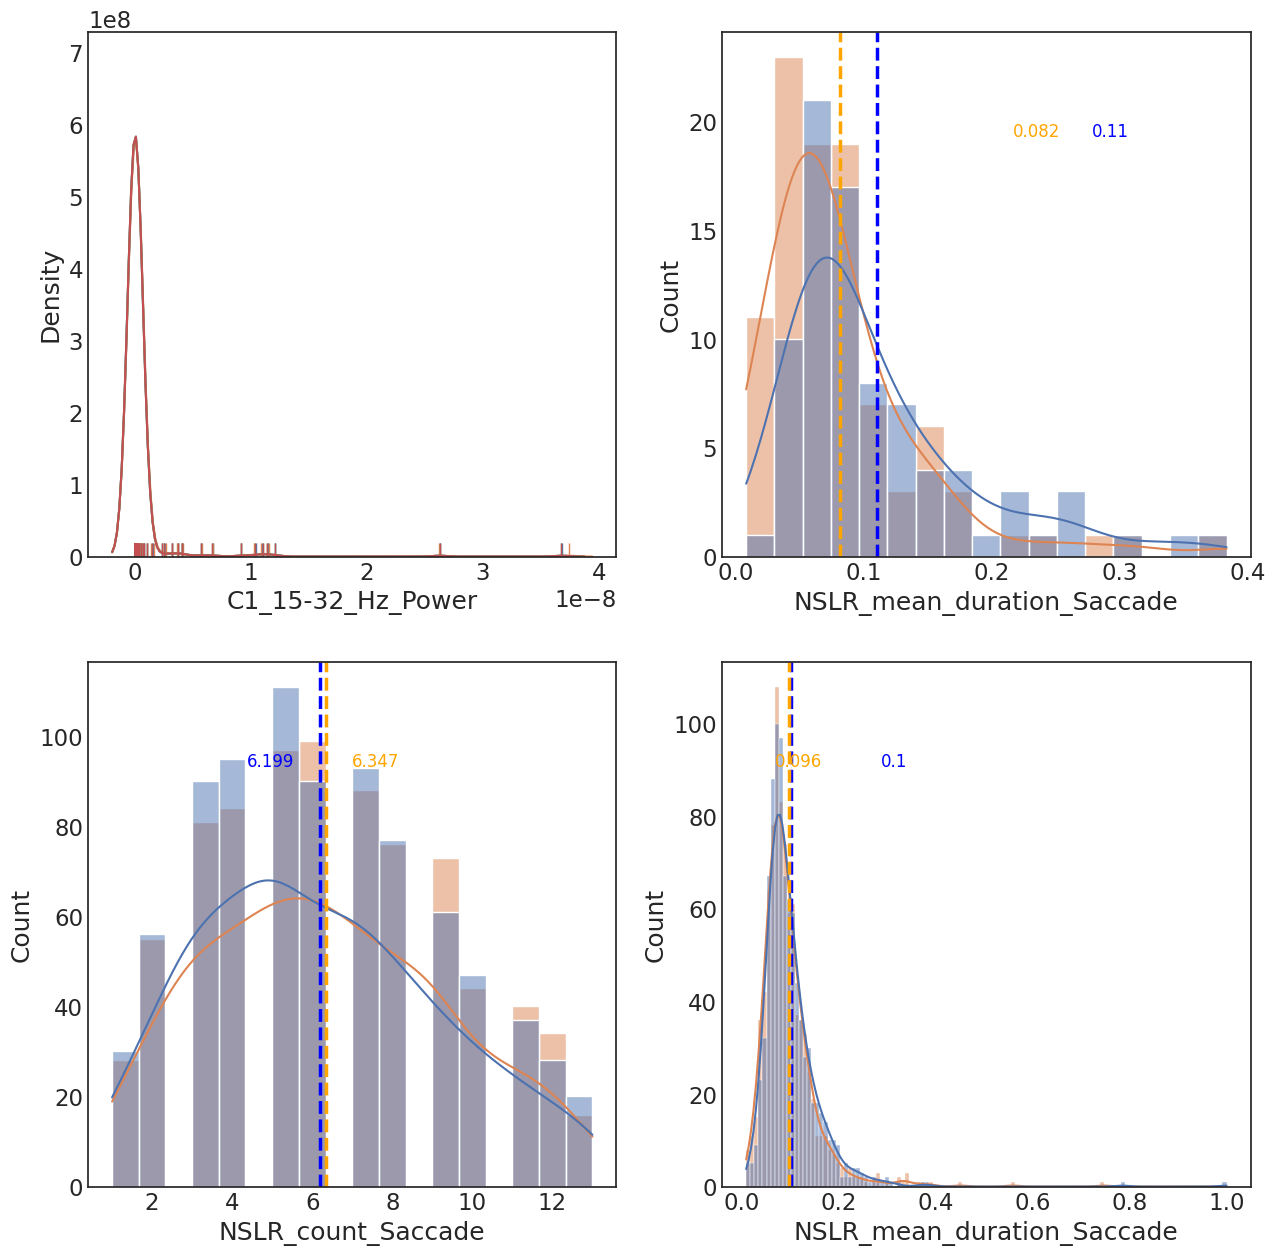

In [59]:
fig, axs = plt.subplots(2, 2, figsize=(15, 15))
channels = ['FC1_15-32_Hz_Power', 'FC3_15-32_Hz_Power', 'C1_15-32_Hz_Power', 'C3_15-32_Hz_Power']
left_measure = 'NSLR_count_Saccade'
right_measure = 'NSLR_mean_duration_Saccade'
hue='pupil_bin'
hue_order = ['low','high']
sns.distplot(motor_dfs[channels[0]], hist=False, rug=True, ax=axs[0, 0])
sns.distplot(motor_dfs[channels[1]], hist=False, rug=True, ax=axs[0, 0])
sns.distplot(motor_dfs[channels[2]], hist=False, rug=True, ax=axs[0, 0])
sns.distplot(motor_dfs[channels[3]], hist=False, rug=True, ax=axs[0, 0])

sns.histplot(data=motor_dfs, x=right_measure, legend=False, kde=True, ax=axs[0, 1], hue=hue, hue_order=hue_order)
axs[0, 1].axvline(x=motor_dfs.loc[motor_dfs[hue]==hue_order[0],right_measure].mean(),
            color='blue',
            ls='--', 
            lw=2.5)
axs[0, 1].text(1.9,.8, round(motor_dfs.loc[motor_dfs[hue]==hue_order[0],right_measure].mean(),3), color='blue', fontsize = 12, transform=axs[0, 0].transAxes)
axs[0, 1].axvline(x=motor_dfs.loc[motor_dfs[hue]==hue_order[1],right_measure].mean(),
            color='orange',
            ls='--', 
            lw=2.5)
axs[0, 1].text(1.75,.8, round(motor_dfs.loc[motor_dfs[hue]==hue_order[1],right_measure].mean(),3), color='orange', fontsize = 12, transform=axs[0, 0].transAxes)

sns.histplot(data=trial_dfs, x=left_measure, kde=True, legend=False, ax=axs[1, 0], hue=hue, hue_order=hue_order)
axs[1, 0].axvline(x=trial_dfs.loc[trial_dfs[hue]==hue_order[0],left_measure].mean(),
            color='blue',
            ls='--', 
            lw=2.5)
axs[1, 0].text(0.3,-.4, round(trial_dfs.loc[trial_dfs[hue]==hue_order[0],left_measure].mean(),3), color='blue', fontsize = 12, transform=axs[0, 0].transAxes)
axs[1, 0].axvline(x=trial_dfs.loc[trial_dfs[hue]==hue_order[1],left_measure].mean(),
            color='orange',
            ls='--', 
            lw=2.5)
axs[1, 0].text(0.5,-.4, round(trial_dfs.loc[trial_dfs[hue]==hue_order[1],left_measure].mean(),3), color='orange', fontsize = 12, transform=axs[0, 0].transAxes)

sns.histplot(data=trial_dfs, x=right_measure, kde=True, ax=axs[1, 1], hue=hue, hue_order=hue_order)
axs[1, 1].axvline(x=trial_dfs.loc[trial_dfs[hue]==hue_order[0],right_measure].mean(),
            color='blue',
            ls='--', 
            lw=2.5)
axs[1, 1].text(1.5,-.4, round(trial_dfs.loc[trial_dfs[hue]==hue_order[0],right_measure].mean(),3), color='blue', fontsize = 12, transform=axs[0, 0].transAxes)
axs[1, 1].axvline(x=trial_dfs.loc[trial_dfs[hue]==hue_order[1],right_measure].mean(),
            color='orange',
            ls='--', 
            lw=2.5)
axs[1, 1].text(1.3,-.4, round(trial_dfs.loc[trial_dfs[hue]==hue_order[1],right_measure].mean(),3), color='orange', fontsize = 12, transform=axs[0, 0].transAxes)


plt.legend() 
plt.show()

# Read Results

In [5]:
all_dfs = pd.read_excel(f"{output_dir}all_results_motor.xlsx")

Text(0.5, 1.0, 'Proportional time into the trial when voice feedback was recognized')

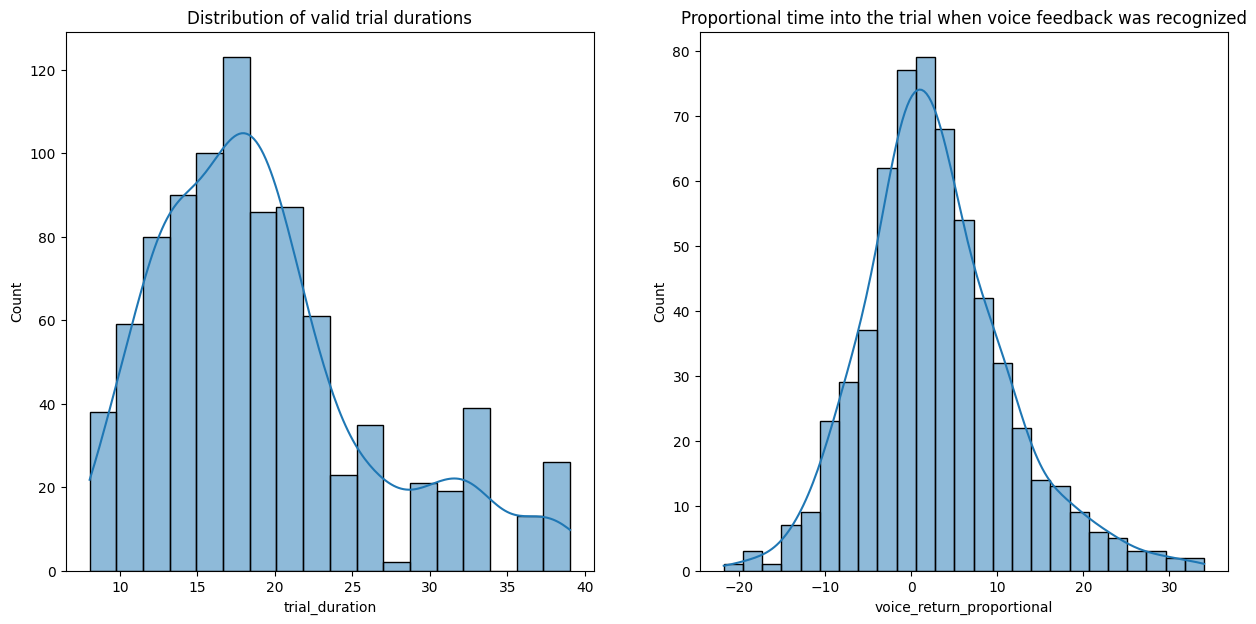

In [8]:
%matplotlib inline

import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

all_dfs_final = all_dfs.copy()
all_dfs_final = all_dfs_final[all_dfs_final.trial_duration <= 40]
all_dfs_final.voice_timestamp = all_dfs_final.voice_timestamp - 1
all_dfs_final['voice_return_proportional'] = (all_dfs_final.voice_timestamp-all_dfs_final.trial_start_time)/(all_dfs_final.trial_end_time-all_dfs_final.trial_start_time)
fig, axs = plt.subplots(1, 2, figsize=(15, 7))

sns.histplot(data=all_dfs_final, x="trial_duration", kde=True, ax=axs[0])
sns.histplot(data=all_dfs_final, x="voice_return_proportional", kde=True, ax=axs[1])
axs[0].set_title('Distribution of valid trial durations')
axs[1].set_title('Proportional time into the trial when voice feedback was recognized')

# Data filtering and prep

In [ ]:
# seaborn
sns.set(font_scale=1.2)
sns.set_palette("tab10")
from mna.utils.batch_feature_extraction import clean_up_adadrive_trials
all_dfs_final = clean_up_adadrive_trials(all_dfs)
cols_of_interest = ["bpm", "density", "trial_duration", "trial_damage",
                                         "abs_sum_delta_steer_input", "abs_sum_delta_brake_input",
                                         "NSLR_count_Fixation", "NSLR_count_Saccade"]
experimental_cols = ['spoken_difficulty', 'trial_duration', 'density', 'trial_damage']
eye_cols = ['spoken_difficulty','Left Pupil Diameter', "NSLR_count_Fixation", "NSLR_count_Saccade",
            'NSLR_mean_duration_Fixation','NSLR_mean_duration_Saccade',
           'NSLR_first_onset_Fixation', 'NSLR_first_onset_Saccade']
ecg_cols = ['spoken_difficulty','density','bpm','sdnn', 'rmssd','pnn50'] # rmssd = parasympathetic
motor_cols = ['spoken_difficulty','density','abs_sum_delta_steer_input','abs_sum_delta_brake_input', 'abs_sum_delta_throttle_input'] 


# damage change
all_dfs_final = all_dfs_final.sort_values(by=['ppid', 'session', 'block'])

# nan, outliers
for col in cols_of_interest:
    all_dfs_final[col] = all_dfs_final[col].mask(all_dfs_final[col].sub(all_dfs_final[col].mean()).div(all_dfs_final[col].std()).abs().gt(2))
all_dfs_final['abs_sum_delta_brake_input'] = all_dfs_final['abs_sum_delta_brake_input'].mask(all_dfs_final['abs_sum_delta_brake_input']>.1)
all_dfs_final['NSLR_first_onset_Fixation'] = all_dfs_final['NSLR_first_onset_Fixation']-all_dfs_final['trial_start_time']
all_dfs_final['NSLR_first_onset_Saccade'] = all_dfs_final['NSLR_first_onset_Saccade']-all_dfs_final['trial_start_time']
all_dfs_final['bpm'] = all_dfs_final['bpm'].mask((all_dfs_final['bpm']<40) | (all_dfs_final['bpm']>150))

# 10-19-22 Meeting

In [9]:
# seaborn
%matplotlib inline

sns.set(font_scale=1.2)
sns.set_palette("tab10")
from mna.utils.batch_feature_extraction import clean_up_adadrive_trials
all_dfs_final = clean_up_adadrive_trials(all_dfs)
cols_of_interest = ["bpm", "density", "trial_duration", "trial_damage",
                                         "NSLR_count_Fixation", "NSLR_count_Saccade"]
experimental_cols = ['spoken_difficulty', 'trial_duration', 'density', 'trial_damage']
eye_cols = ['spoken_difficulty','Left Pupil Diameter', "NSLR_count_Fixation", "NSLR_count_Saccade",
            'NSLR_mean_duration_Fixation','NSLR_mean_duration_Saccade',
           'NSLR_first_onset_Fixation', 'NSLR_first_onset_Saccade']
ecg_cols = ['spoken_difficulty','density','bpm','sdnn', 'rmssd','pnn50'] # rmssd = parasympathetic
motor_cols = ['spoken_difficulty','density','abs_sum_delta_steer_input','abs_sum_delta_brake_input', 'abs_sum_delta_throttle_input'] 


# damage change
all_dfs_final = all_dfs_final.sort_values(by=['ppid', 'session', 'block'])

# nan, outliers
for col in cols_of_interest:
    all_dfs_final[col] = all_dfs_final[col].mask(all_dfs_final[col].sub(all_dfs_final[col].mean()).div(all_dfs_final[col].std()).abs().gt(2))
all_dfs_final['NSLR_first_onset_Fixation'] = all_dfs_final['NSLR_first_onset_Fixation']-all_dfs_final['trial_start_time']
all_dfs_final['NSLR_first_onset_Saccade'] = all_dfs_final['NSLR_first_onset_Saccade']-all_dfs_final['trial_start_time']
all_dfs_final['bpm'] = all_dfs_final['bpm'].mask((all_dfs_final['bpm']<40) | (all_dfs_final['bpm']>150))

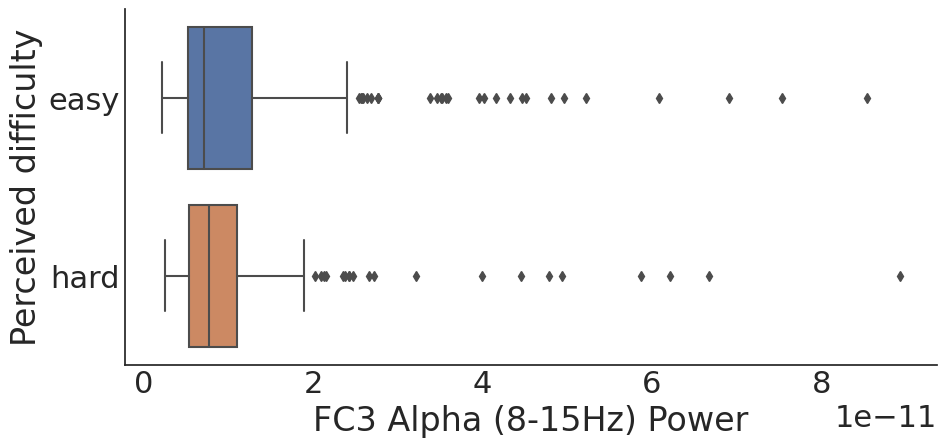

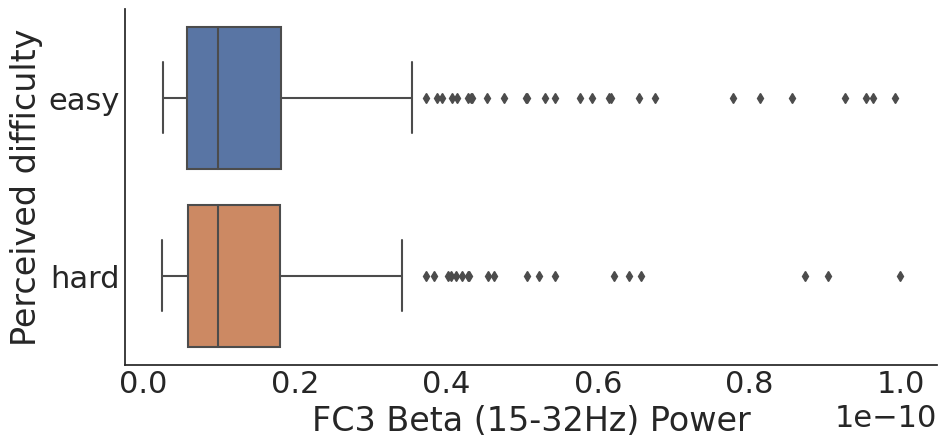

In [19]:
sns.set(font_scale=2)
plt.style.use('seaborn-white')

def plot_eeg_comparison(channel, frequency, plot_label_freq):
    # some preliminary filters for data viz
    coe_eeg_copy = all_dfs_final.copy()
    coe_eeg_copy = coe_eeg_copy.loc[coe_eeg_copy[f"{channel}_{frequency}_Hz_Power"] < 1e-10]
    g = sns.catplot(data=coe_eeg_copy, y="spoken_difficulty", x=f"{channel}_{frequency}_Hz_Power", kind="box", order=['easy','hard'], aspect=2)
    g.set_axis_labels(f"{channel} {plot_label_freq} ({frequency}Hz) Power", "Perceived difficulty")
    #plt.savefig('output/coe_eeg.png', dpi=300)

plot_eeg_comparison('FC1', '8-15', 'Alpha')
plot_eeg_comparison('FC3', '15-32', 'Beta')




# 10-12-22 Meeting

## Opacity effects on pupil diameter

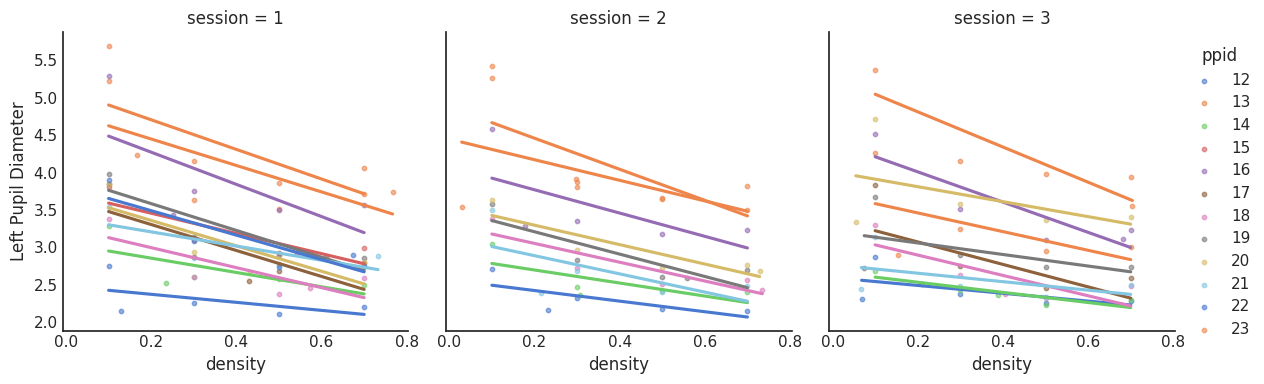

In [88]:
# performance measure: speeed

sns.set(font_scale=1)
plt.style.use('seaborn-white')
practice_df = all_dfs[all_dfs.block_condition=='practice']
sns.lmplot(
    data=practice_df, x="density", y="Left Pupil Diameter", col="session", hue="ppid",
    palette="muted", ci=None, row_order=['easy','hard'],
    height=4, scatter_kws={"s": 10, "alpha": .6}
)


## Practice effect?

In [15]:
all_dfs_final

trial_start_time  trial_end_time  ppid  session  block  number_in_block  \
74        4165.101293     4166.101293  12.0      1.0    3.0              6.0   
75        4167.728635     4168.728635  12.0      1.0    3.0              6.0   
76        4334.812631     4335.812631  12.0      1.0    5.0              2.0   
77        4337.220045     4338.220045  12.0      1.0    5.0              2.0   
78        4339.395124     4340.395124  12.0      1.0    5.0              2.0   
..                ...             ...   ...      ...    ...              ...   
918       2561.997082     2562.997082  23.0      3.0   15.0              3.0   
919       2704.613626     2705.613626  23.0      3.0   16.0              4.0   
920       2708.541561     2709.541561  23.0      3.0   16.0              4.0   
921       2698.233677     2699.233677  23.0      3.0   16.0              4.0   
922       2707.830386     2708.830386  23.0      3.0   16.0              4.0   

     trial   density      damage  source  ...  PO4_Hjorth_Mobility  \
74    22.0  0.405075   90.767365     2.0  ...                  NaN   
75    22.0  0.405075   90.767365     2.0  ...                  NaN   
76    32.0  0.185976  289.686310     1.0  ...             0.875173   
77    32.0  0.185976  289.686310     1.0  ...             0.680147   
78    32.0  0.185976  289.686310     1.0  ...             0.686686   
..     ...       ...         ...     ...  ...                  ...   
918  103.0  0.537229   73.070412     1.0  ...                  NaN   
919  113.0  0.412569   96.270790     0.0  ...             0.786428   
920  113.0  0.412569   96.270790     0.0  ...             0.556960   
921  113.0  0.412569   96.270790     0.0  ...             0.365115   
922  113.0  0.412569   96.270790     0.0  ...             0.586189   

    O2_Hjorth_Mobility NSLR_count_None  NSLR_first_onset_None  \
74                 NaN             NaN                    NaN   
75                 NaN             NaN                    NaN   
76            1.307919             NaN                    NaN   
77            1.173258             NaN                    NaN   
78            0.995058             NaN                    NaN   
..                 ...             ...                    ...   
918                NaN             NaN                    NaN   
919           1.252853             NaN                    NaN   
920           1.060947             NaN                    NaN   
921           0.770790             NaN                    NaN   
922           1.062869             NaN                    NaN   

    NSLR_mean_duration_None  measures  NSLR_count_Non  NSLR_first_onset_Non  \
74                      NaN       NaN             NaN                   NaN   
75                      NaN       NaN             NaN                   NaN   
76                      NaN       NaN             NaN                   NaN   
77                      NaN       NaN             NaN                   NaN   
78                      NaN       NaN             NaN                   NaN   
..                      ...       ...             ...                   ...   
918                     NaN       NaN             NaN                   NaN   
919                     NaN       NaN             NaN                   NaN   
920                     NaN       NaN             NaN                   NaN   
921                     NaN       NaN             NaN                   NaN   
922                     NaN       NaN             NaN                   NaN   

     NSLR_mean_duration_Non ppid_session  
74                      NaN         12_1  
75                      NaN         12_1  
76                      NaN         12_1  
77                      NaN         12_1  
78                      NaN         12_1  
..                      ...          ...  
918                     NaN         23_3  
919                     NaN         23_3  
920                     NaN         23_3  
921                     NaN         23_3  


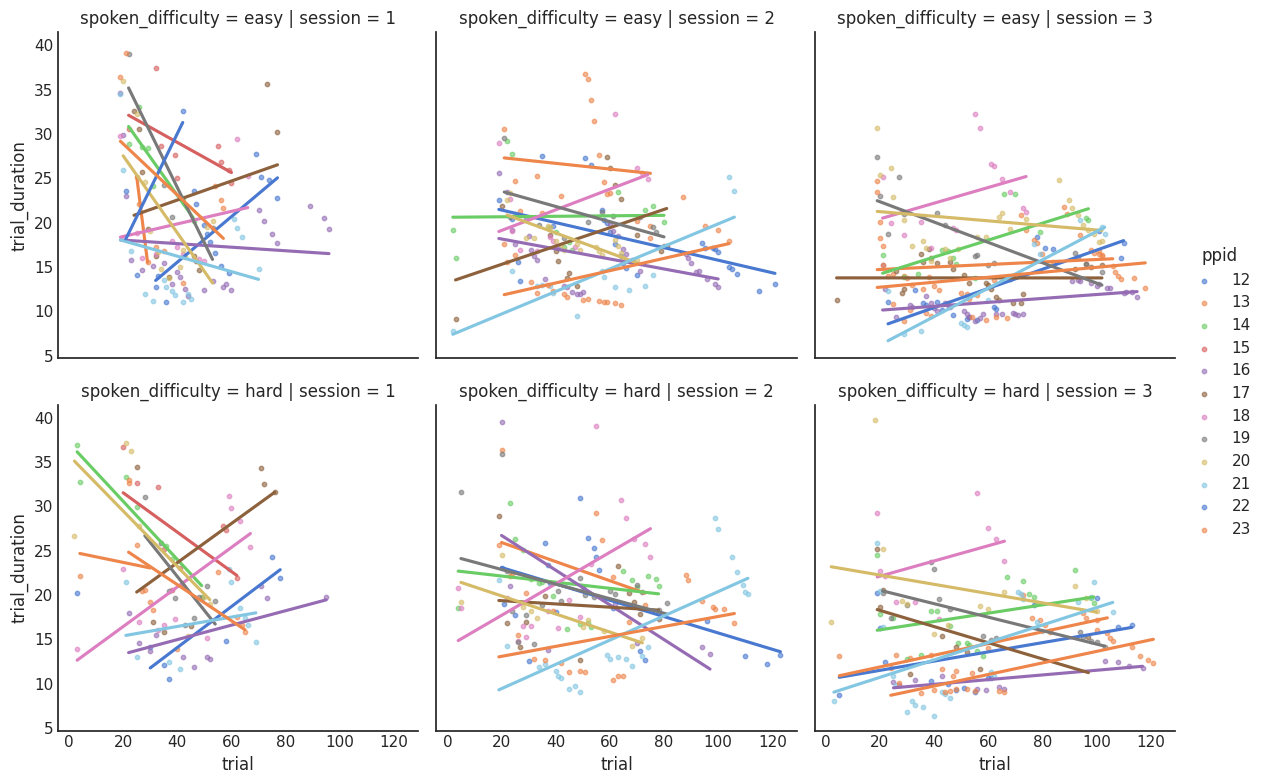

In [7]:
# performance measure: speeed

sns.set(font_scale=1)
plt.style.use('seaborn-white')

sns.lmplot(
    data=all_dfs_final, x="trial", y="trial_duration", col="session", hue="ppid", row='spoken_difficulty',
    palette="muted", ci=None, row_order=['easy','hard'],
    height=4, scatter_kws={"s": 10, "alpha": .6}
)


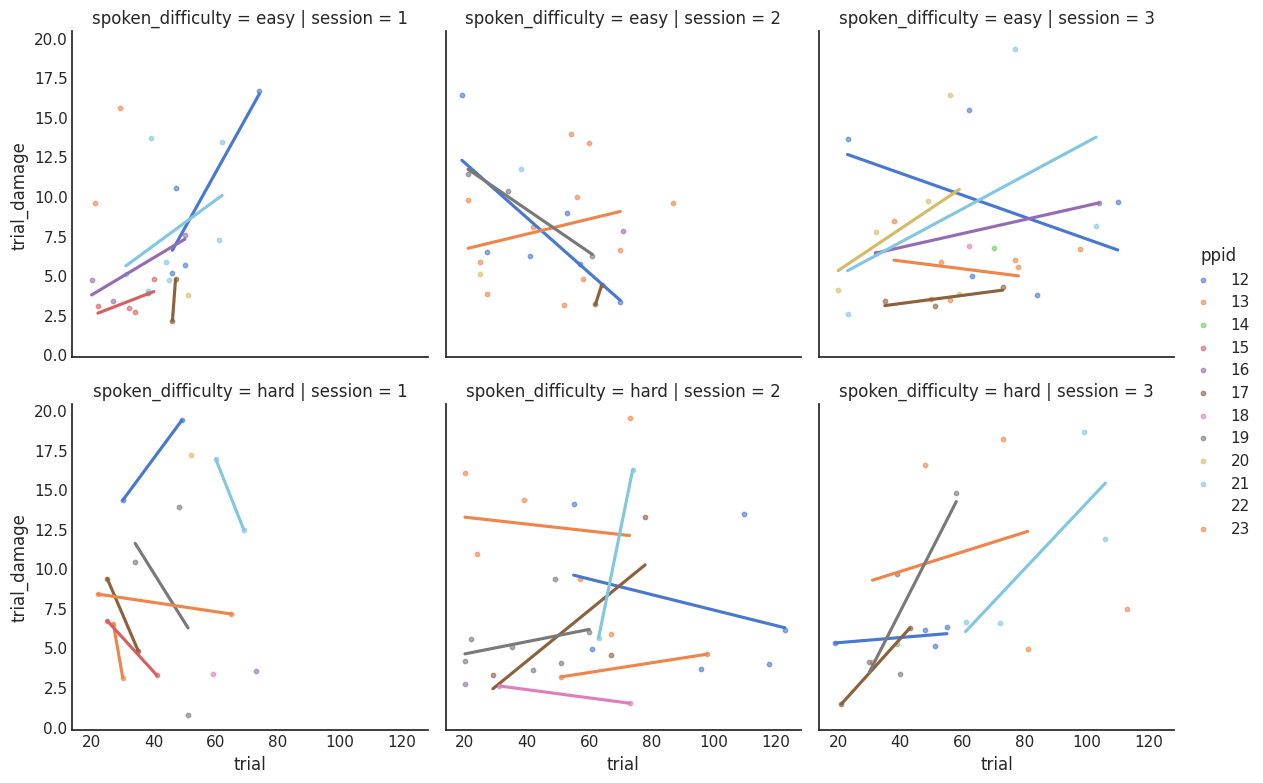

In [84]:
# performance measure: damange

sns.set(font_scale=1)
plt.style.use('seaborn-white')
trial_damage_df = all_dfs_final[all_dfs_final.trial_damage > 0]
sns.lmplot(
    data=trial_damage_df, x="trial", y="trial_damage", col="session", hue="ppid", row='spoken_difficulty',
    palette="muted", ci=None, row_order=['easy','hard'],
    height=4, scatter_kws={"s": 10, "alpha": .6}
)


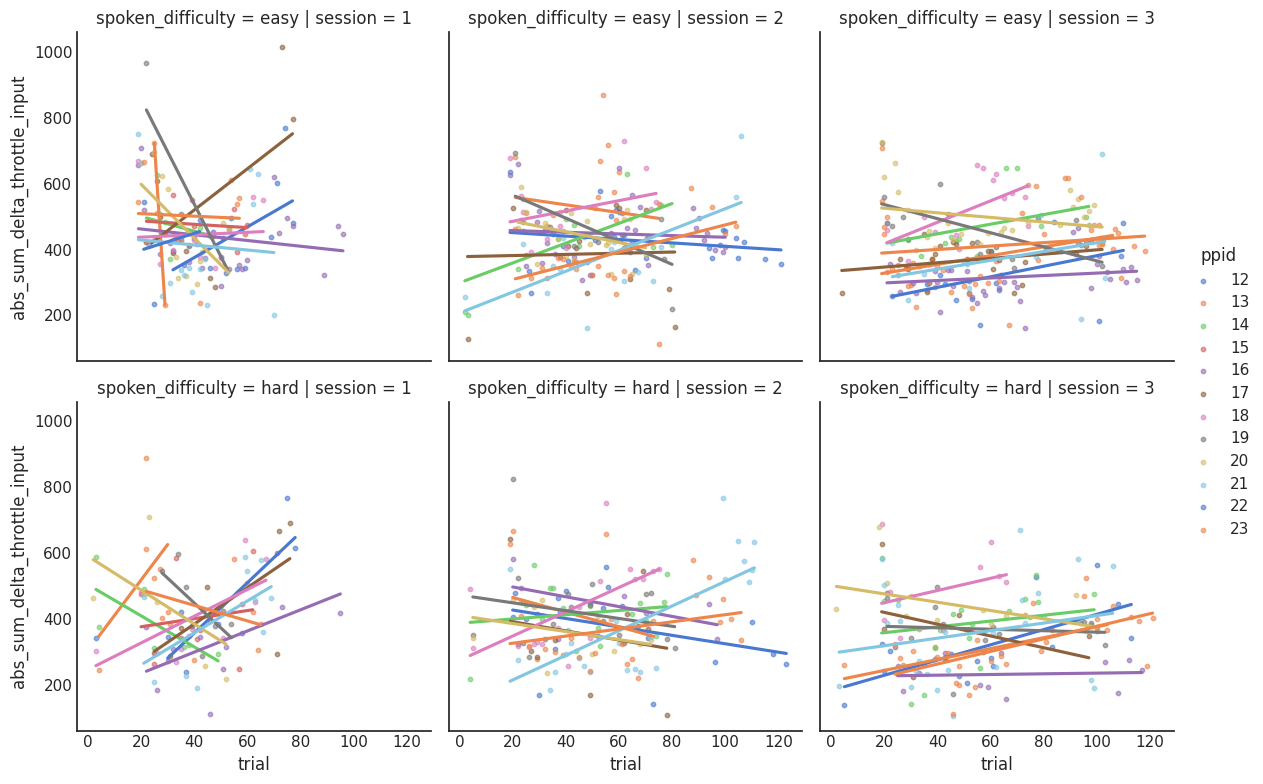

In [14]:
# performance measure: throttle input

sns.set(font_scale=1)
plt.style.use('seaborn-white')

sns.lmplot(
    data=all_dfs_final, x="trial", y="abs_sum_delta_throttle_input", col="session", hue="ppid", row='spoken_difficulty',
    palette="muted", ci=None, row_order=['easy','hard'],
    height=4, scatter_kws={"s": 10, "alpha": .6}
)


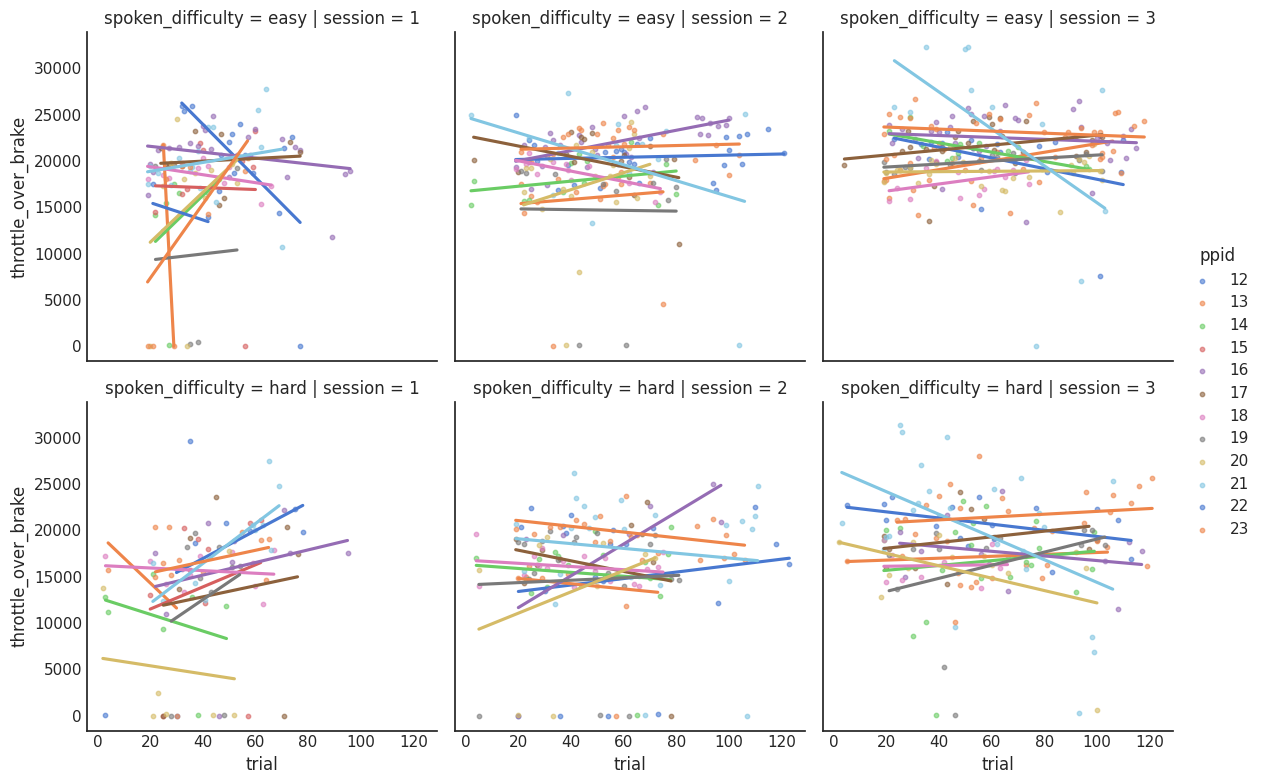

In [17]:
# performance measure: throttle input

sns.set(font_scale=1)
plt.style.use('seaborn-white')
performance_df = all_dfs_final.copy()
performance_df['throttle_over_brake'] = performance_df.abs_sum_delta_throttle_input/performance_df.abs_sum_delta_brake_input
sns.lmplot(
    data=performance_df, x="trial", y="throttle_over_brake", col="session", hue="ppid", row='spoken_difficulty',
    palette="muted", ci=None, row_order=['easy','hard'],
    height=4, scatter_kws={"s": 10, "alpha": .6}
)


In [ ]:
sns.regplot(x="trial_damage", y="throttle_over_brake", data=performance_df);

### Arousal performance relationship

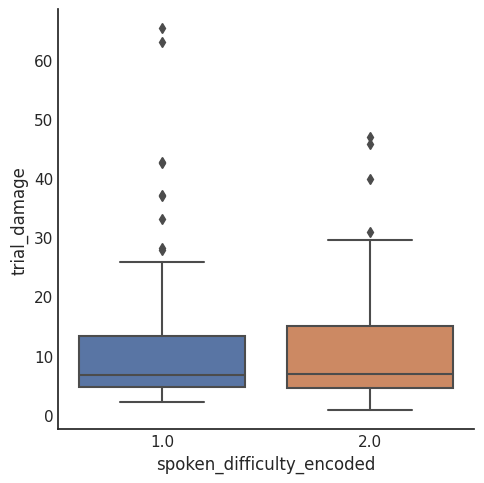

In [31]:
# perceived arousal
sns.catplot(x="spoken_difficulty_encoded", y="trial_damage", data=performance_df[performance_df.trial_damage > 0], kind="box");

# pupil-linked arousal
# sns.regplot(x="Left Pupil Diameter", y="throttle_over_brake", data=performance_df);

## Other

In [21]:
# quality measurse
speech_recognition = pd.DataFrame(all_dfs_final.groupby("ppid_session").apply(lambda x: x['spoken_difficulty'].notnull().mean()))
display('speech_recognition_min',speech_recognition.min().values,
        'speech_recognition_max',speech_recognition.max(),
        'speech_recognition.mean', speech_recognition.mean())
autorejected = pd.DataFrame(all_dfs_final.groupby("ppid_session").apply(lambda x: np.nansum(x['autorejected'])/len(x['autorejected'])))
display('autorejected_trials_min',autorejected.min(),
        'autorejected_trials_max',autorejected.max(),
        'autorejected_trials_mean', autorejected.mean())
bad_beats = pd.DataFrame(all_dfs_final.groupby("ppid_session").apply(lambda x: x['removed_beat_rate']))
display('bad_beats_perc_min',bad_beats.min(),
        'bad_beats_perc_max',bad_beats.max(),
        'bad_beats_perc_mean', bad_beats.mean())


'speech_recognition_min'

array([0.35])

'speech_recognition_max'

0    0.634146
dtype: float64

'speech_recognition.mean'

0    0.516047
dtype: float64

'autorejected_trials_min'

0    0.0
dtype: float64

'autorejected_trials_max'

0    0.339286
dtype: float64

'autorejected_trials_mean'

0    0.041427
dtype: float64

'bad_beats_perc_min'

removed_beat_rate    0.0
dtype: float64

'bad_beats_perc_max'

removed_beat_rate    0.769231
dtype: float64

'bad_beats_perc_mean'

removed_beat_rate    0.219213
dtype: float64

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


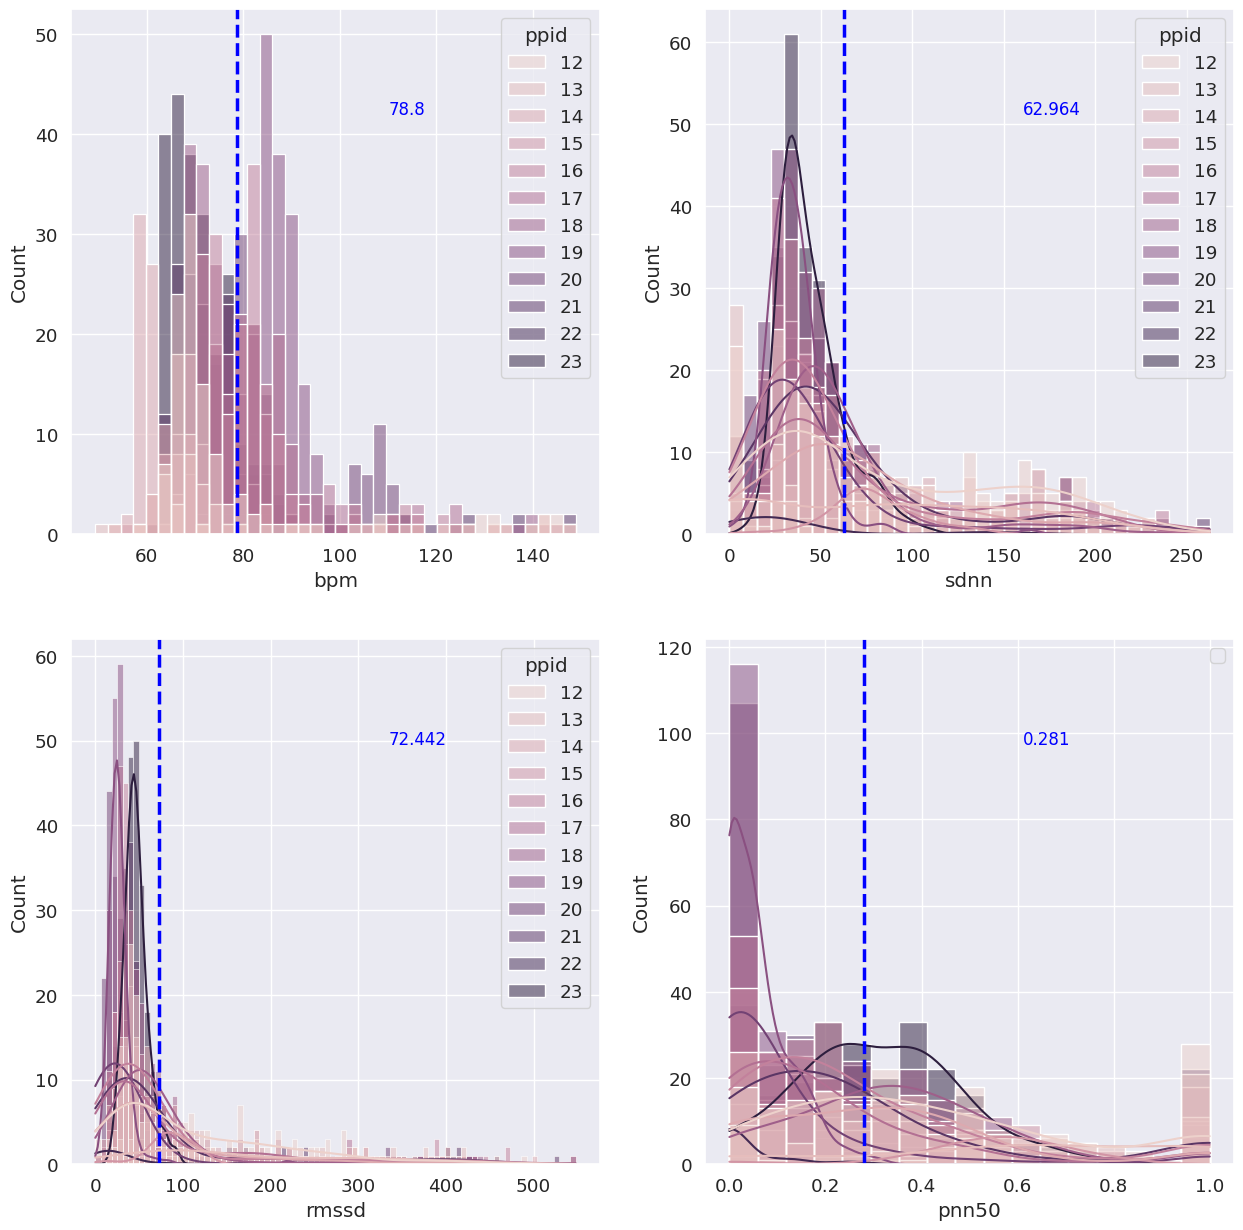

In [22]:
fig, axs = plt.subplots(2, 2, figsize=(15, 15))
sns.histplot(data=all_dfs_final, x="bpm", kde=False, color="skyblue", label="Sepal Length", ax=axs[0, 0], hue='ppid')
axs[0, 0].axvline(x=all_dfs_final.bpm.mean(),
            color='blue',
            ls='--', 
            lw=2.5)
axs[0, 0].text(0.6,.8, round(all_dfs_final.bpm.mean(),3), color='blue', fontsize = 12, transform=axs[0, 0].transAxes)


sns.histplot(data=all_dfs_final, x="sdnn", kde=True, color="olive", ax=axs[0, 1], hue='ppid')
axs[0, 1].axvline(x=all_dfs_final.sdnn.mean(),
            color='blue',
            ls='--', 
            lw=2.5)
axs[0, 1].text(0.6,.8, round(all_dfs_final.sdnn.mean(),3), color='blue', fontsize = 12, transform=axs[0, 1].transAxes)


sns.histplot(data=all_dfs_final, x="rmssd", kde=True, color="gold", ax=axs[1, 0], hue='ppid')
axs[1, 0].axvline(x=all_dfs_final.rmssd.mean(),
            color='blue',
            ls='--', 
            lw=2.5)
axs[1, 0].text(0.6,.8, round(all_dfs_final.rmssd.mean(),3), color='blue', fontsize = 12, transform=axs[1, 0].transAxes)


sns.histplot(data=all_dfs_final, x="pnn50", kde=True, color="teal", ax=axs[1, 1], hue='ppid')
axs[1, 1].axvline(x=all_dfs_final.pnn50.mean(),
            color='blue',
            ls='--', 
            lw=2.5)
axs[1, 1].text(0.6,.8, round(all_dfs_final.pnn50.mean(),3), color='blue', fontsize = 12, transform=axs[1, 1].transAxes)


plt.legend() 
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


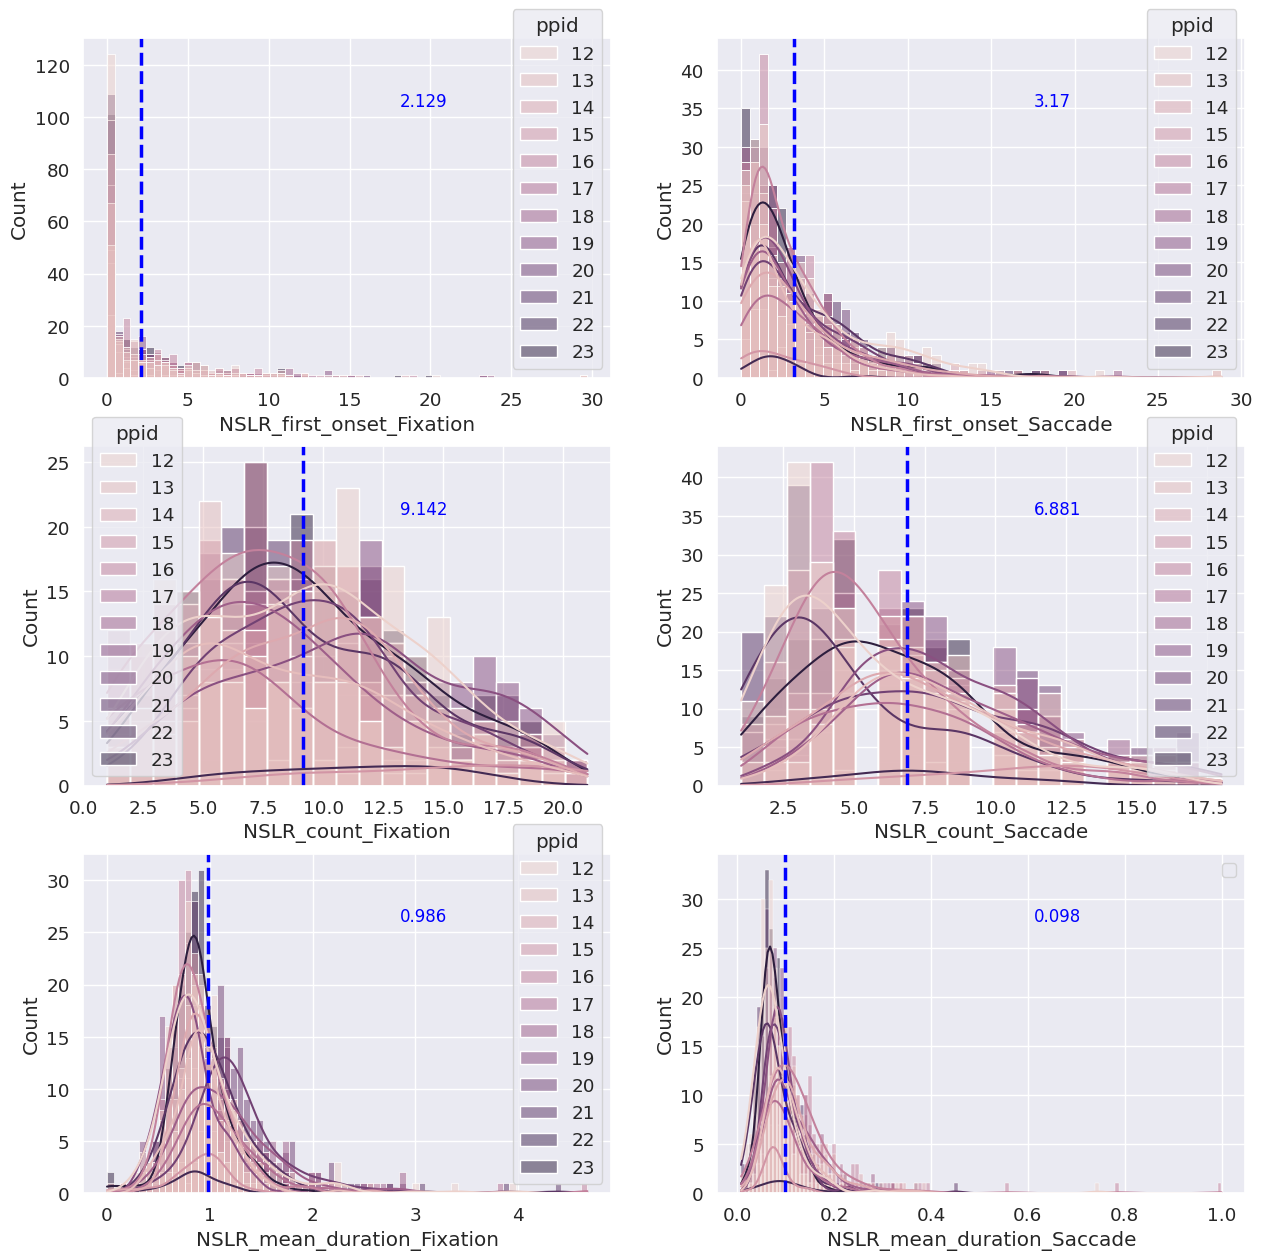

In [26]:
fig, axs = plt.subplots(3, 2, figsize=(15, 15))
sns.histplot(data=all_dfs_final, x="NSLR_first_onset_Fixation", kde=False, color="skyblue", label="Sepal Length", ax=axs[0, 0], hue='ppid')
axs[0, 0].axvline(x=all_dfs_final.NSLR_first_onset_Fixation.mean(),
            color='blue',
            ls='--', 
            lw=2.5)
axs[0, 0].text(0.6,.8, round(all_dfs_final.NSLR_first_onset_Fixation.mean(),3), color='blue', fontsize = 12, transform=axs[0, 0].transAxes)


sns.histplot(data=all_dfs_final, x="NSLR_first_onset_Saccade", kde=True, color="olive", ax=axs[0, 1], hue='ppid')
axs[0, 1].axvline(x=all_dfs_final.NSLR_first_onset_Saccade.mean(),
            color='blue',
            ls='--', 
            lw=2.5)
axs[0, 1].text(0.6,.8, round(all_dfs_final.NSLR_first_onset_Saccade.mean(),3), color='blue', fontsize = 12, transform=axs[0, 1].transAxes)


sns.histplot(data=all_dfs_final, x="NSLR_count_Fixation", kde=True, color="gold", ax=axs[1, 0], hue='ppid')
axs[1, 0].axvline(x=all_dfs_final.NSLR_count_Fixation.mean(),
            color='blue',
            ls='--', 
            lw=2.5)
axs[1, 0].text(0.6,.8, round(all_dfs_final.NSLR_count_Fixation.mean(),3), color='blue', fontsize = 12, transform=axs[1, 0].transAxes)


sns.histplot(data=all_dfs_final, x="NSLR_count_Saccade", kde=True, color="teal", ax=axs[1, 1], hue='ppid')
axs[1, 1].axvline(x=all_dfs_final.NSLR_count_Saccade.mean(),
            color='blue',
            ls='--', 
            lw=2.5)
axs[1, 1].text(0.6,.8, round(all_dfs_final.NSLR_count_Saccade.mean(),3), color='blue', fontsize = 12, transform=axs[1, 1].transAxes)


sns.histplot(data=all_dfs_final, x="NSLR_mean_duration_Fixation", kde=True, color="gold", ax=axs[2, 0], hue='ppid')
axs[2, 0].axvline(x=all_dfs_final.NSLR_mean_duration_Fixation.mean(),
            color='blue',
            ls='--', 
            lw=2.5)
axs[2, 0].text(0.6,.8, round(all_dfs_final.NSLR_mean_duration_Fixation.mean(),3), color='blue', fontsize = 12, transform=axs[2, 0].transAxes)

sns.histplot(data=all_dfs_final, x="NSLR_mean_duration_Saccade", kde=True, color="teal", ax=axs[2, 1], hue='ppid')
axs[2, 1].axvline(x=all_dfs_final.NSLR_mean_duration_Saccade.mean(),
            color='blue',
            ls='--', 
            lw=2.5)
axs[2, 1].text(.6,.8, round(all_dfs_final.NSLR_mean_duration_Saccade.mean(),3), color='blue', fontsize = 12, transform=axs[2, 1].transAxes)

plt.legend() 
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


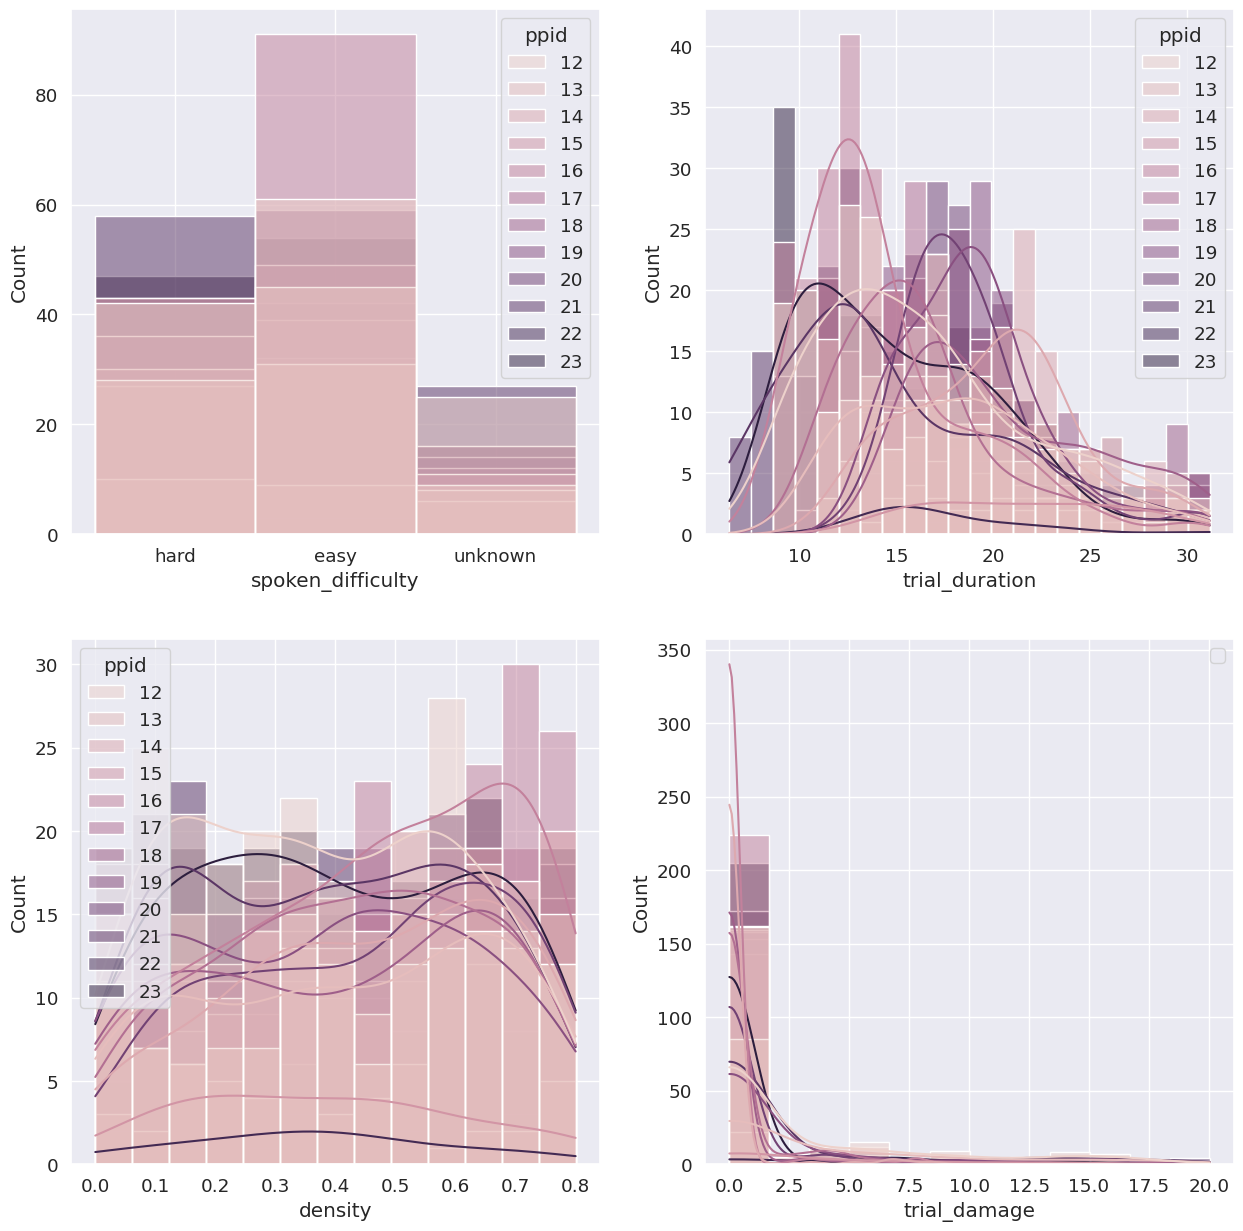

In [28]:
fig, axs = plt.subplots(2, 2, figsize=(15, 15))
sns.histplot(data=all_dfs_final, x="spoken_difficulty", kde=False, color="skyblue", label="Sepal Length", ax=axs[0, 0], hue='ppid')
sns.histplot(data=all_dfs_final, x="trial_duration", kde=True, color="olive", ax=axs[0, 1], hue='ppid')
sns.histplot(data=all_dfs_final, x="density", kde=True, color="gold", ax=axs[1, 0], hue='ppid')
sns.histplot(data=all_dfs_final, x="trial_damage", kde=True, color="teal", ax=axs[1, 1], hue='ppid')

plt.legend() 
plt.show()


## Josef's variables

In [25]:

all_dfs_final.loc[all_dfs_final['spoken_difficulty'] == 'easy', 'spoken_difficulty'] = 1
all_dfs_final.loc[all_dfs_final['spoken_difficulty'] == 'hard', 'spoken_difficulty'] = 2
all_dfs_final.loc[all_dfs_final['spoken_difficulty'] == 'unknown', 'spoken_difficulty'] = np.NAN

all_dfs_final['spoken_difficulty'] = all_dfs_final['spoken_difficulty'].astype(float)

# josef_cols cols
josef_cols = ['spoken_difficulty', 'density',"L Pupil Diameter",  'pnn50', "Oz_8-15_Hz_Power"]

g = sns.pairplot(all_dfs_final[josef_cols+['ppid']], kind="reg", vars=josef_cols,
                 diag_kind="kde",height=4, hue="ppid", plot_kws=dict(ci=None))
log_columns = ["Oz_8-15_Hz_Power"]

for ax in g.axes.flat:
    if ax.get_xlabel() in log_columns:
        ax.set(xscale="log")

KeyError: "['L Pupil Diameter'] not in index"

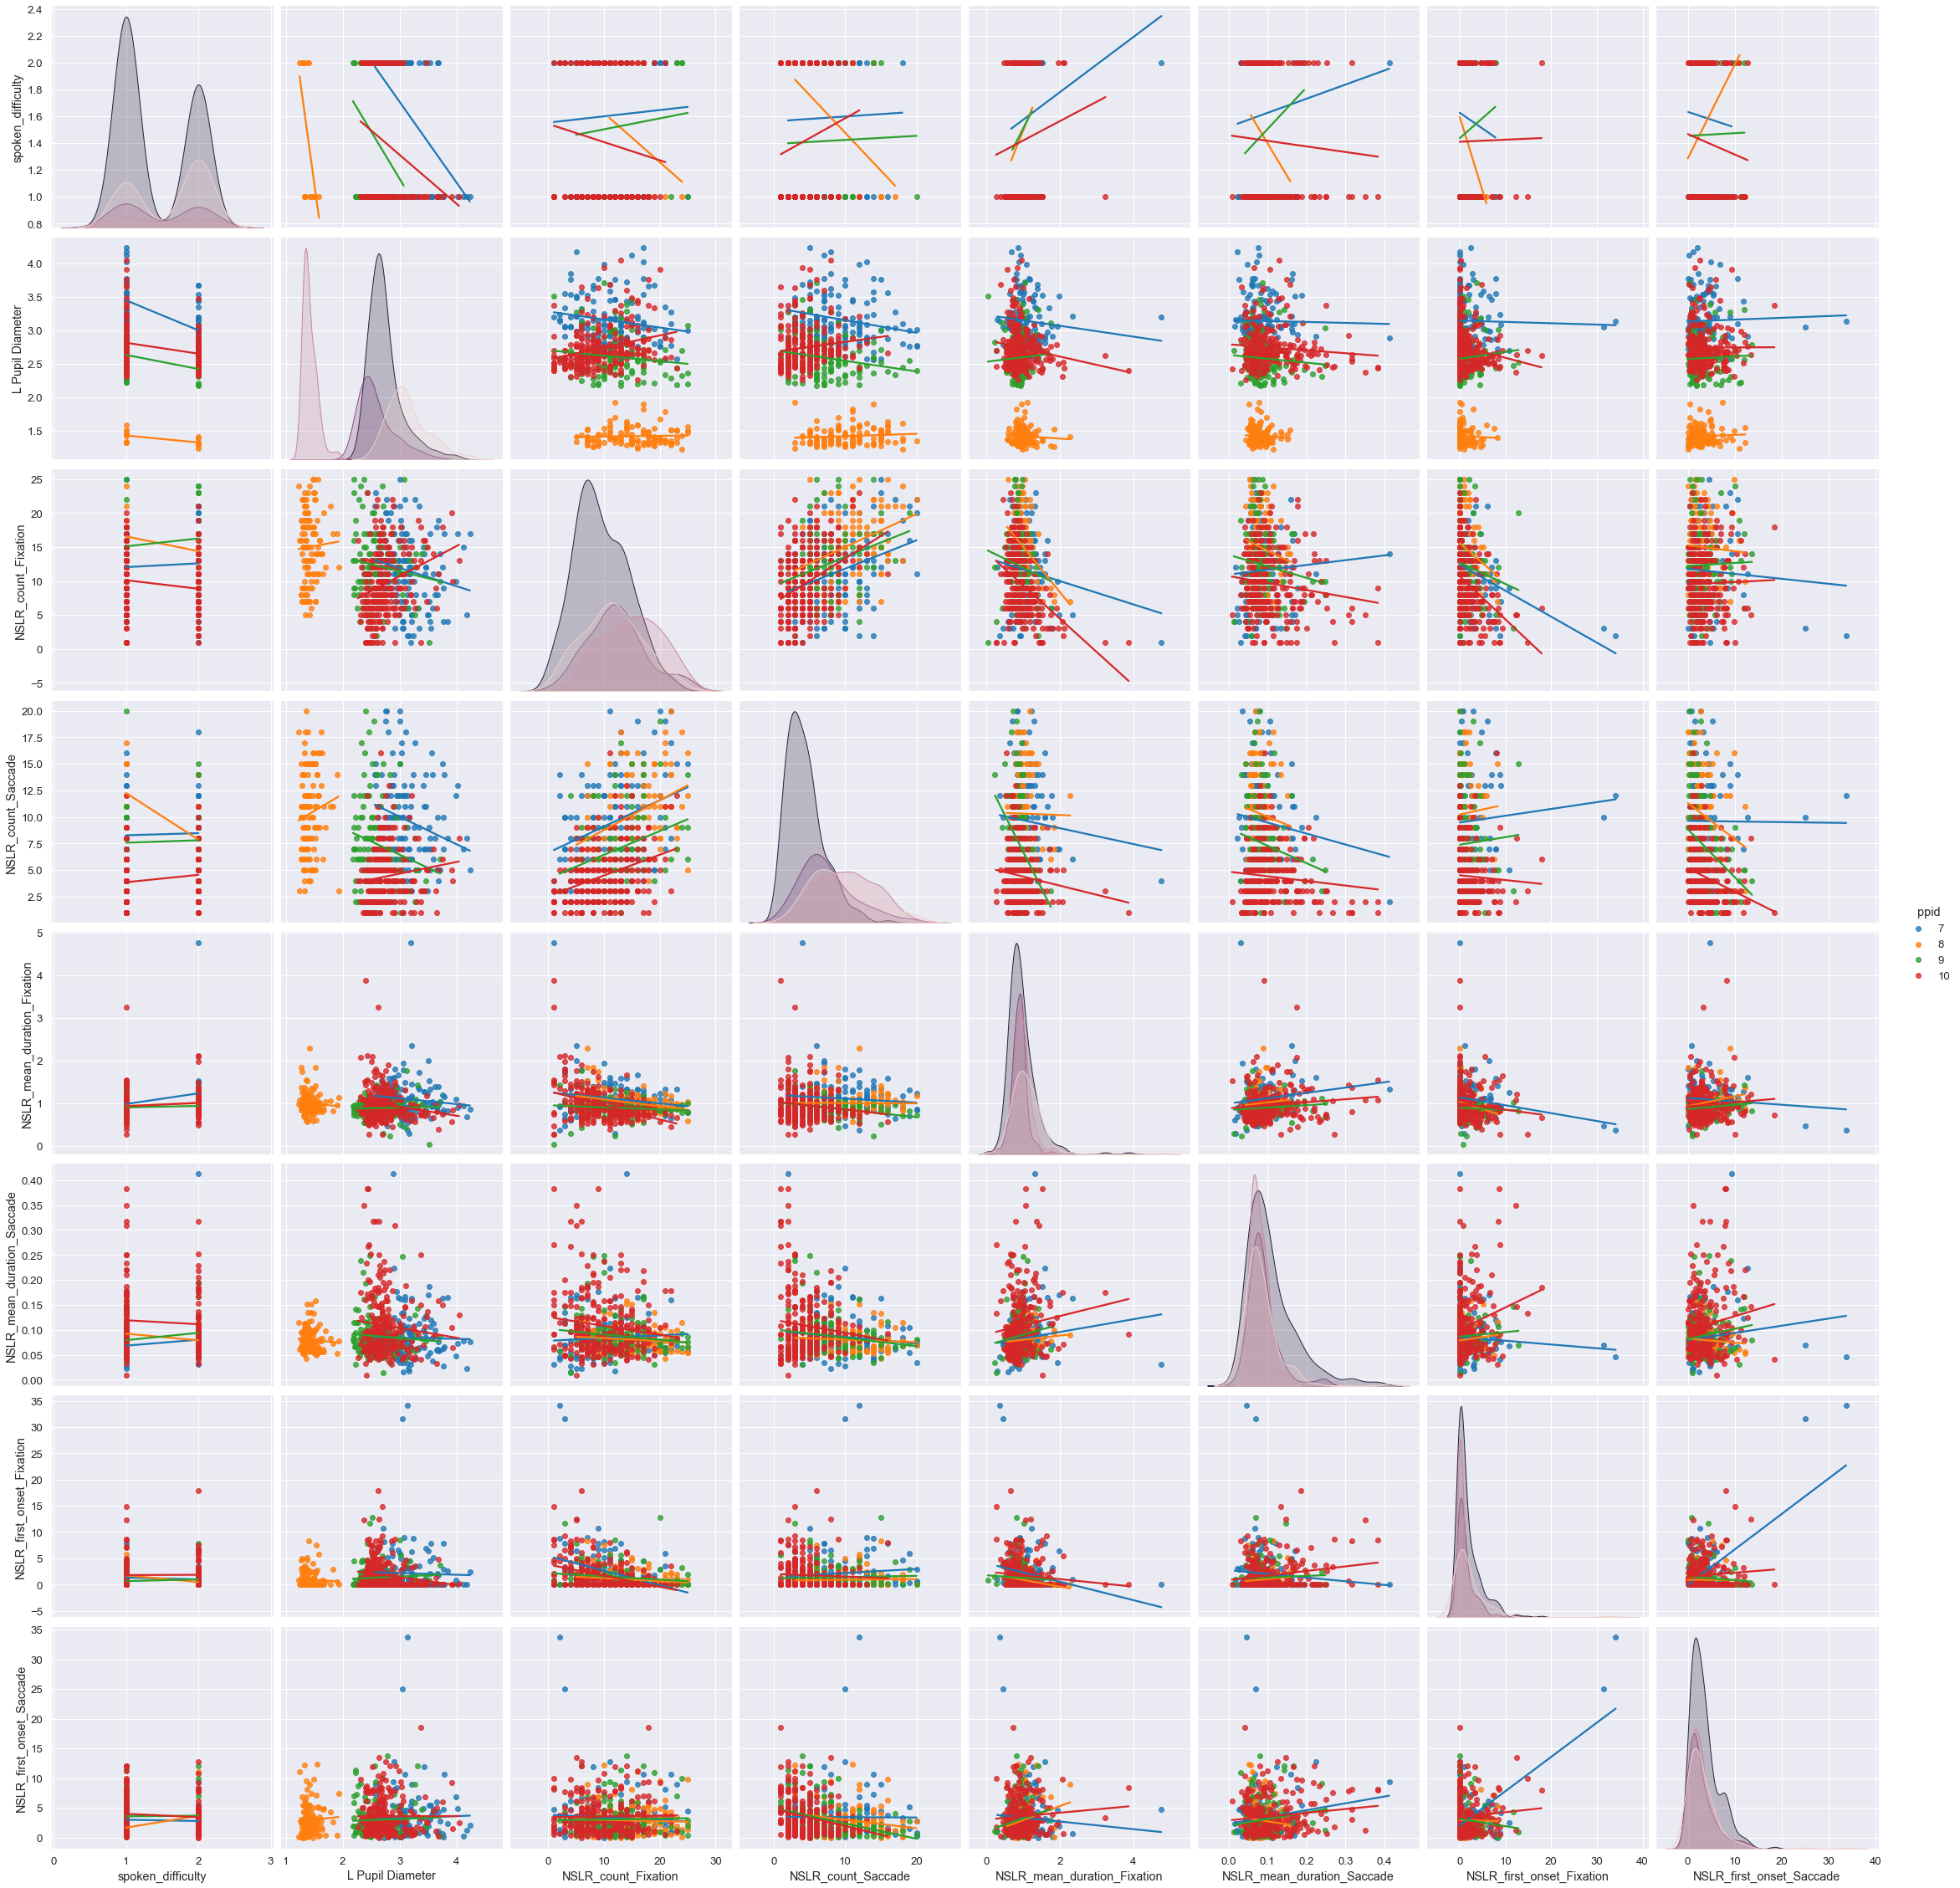

In [145]:
all_dfs_final.loc[all_dfs_final['spoken_difficulty'] == 'easy', 'spoken_difficulty'] = 1
all_dfs_final.loc[all_dfs_final['spoken_difficulty'] == 'hard', 'spoken_difficulty'] = 2
all_dfs_final.loc[all_dfs_final['spoken_difficulty'] == 'unknown', 'spoken_difficulty'] = np.NAN

all_dfs_final['spoken_difficulty'] = all_dfs_final['spoken_difficulty'].astype(float)
#g = sns.pairplot(all_dfs_final[experimental_cols+['ppid_session']], kind="reg", vars=experimental_cols,
#                 diag_kind="kde",height=4, hue="ppid_session", plot_kws=dict(ci=None))

# eye cols
saccade_cols = ['spoken_difficulty', 'density',"NSLR_count_Saccade",'NSLR_mean_duration_Saccade',
           'NSLR_first_onset_Saccade']
#g = sns.pairplot(all_dfs_final[saccade_cols+['ppid_session']], kind="reg", vars=saccade_cols,
#                 diag_kind="kde",height=4, hue="ppid_session", plot_kws=dict(ci=None))

#g = sns.pairplot(all_dfs_final[ecg_cols+['ppid_session']], kind="reg", vars=ecg_cols,
#                 diag_kind="kde",height=4, hue="ppid_session", plot_kws=dict(ci=None))

g = sns.pairplot(all_dfs_final[eye_cols+['ppid']], kind="reg", vars=eye_cols,
                 diag_kind="kde",height=4, hue="ppid", plot_kws=dict(ci=None))

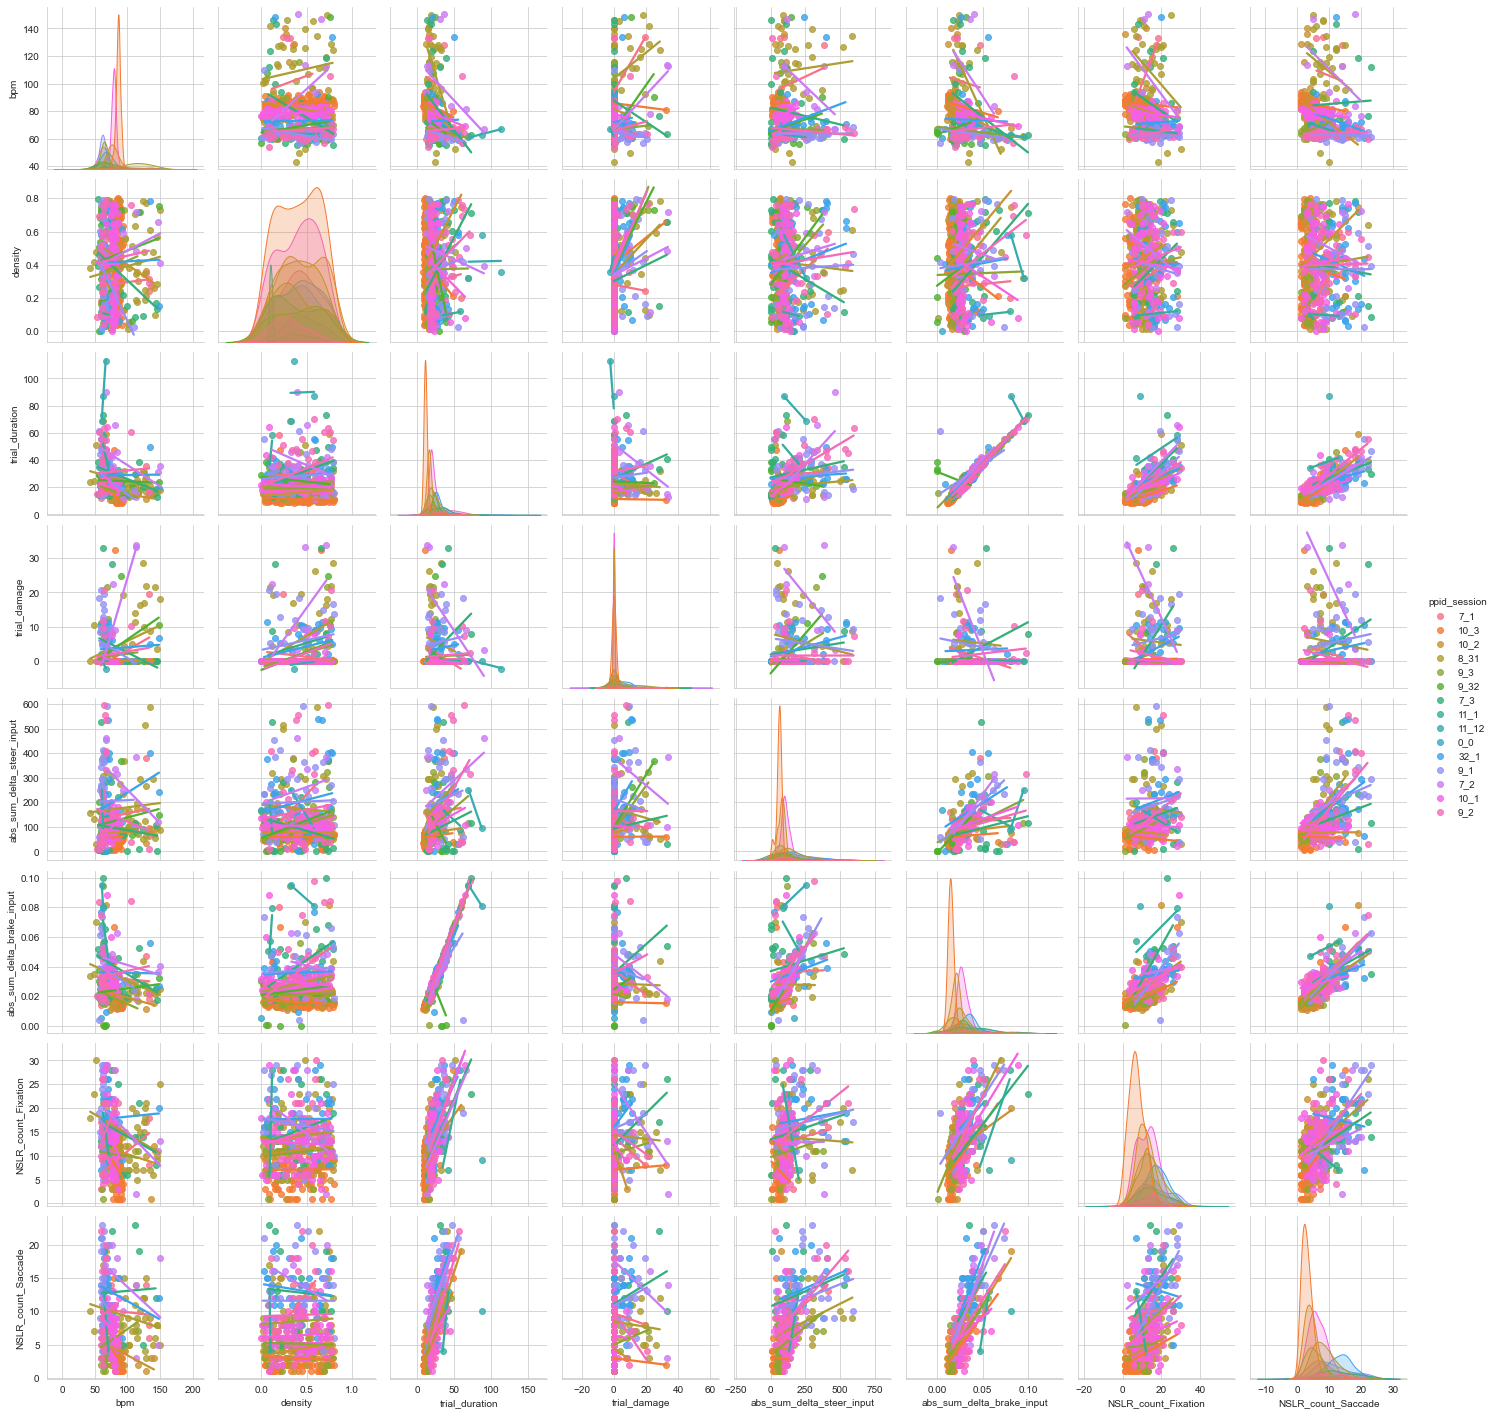

In [58]:
import seaborn as sns
g = sns.pairplot(all_dfs_final, kind="reg", vars=cols_of_interest,
                 diag_kind="kde",height=2.5, hue="ppid_session", plot_kws=dict(ci=None))



In [34]:
all_dfs_final[eye_cols+['ppid_session']].groupby('ppid_session').describe()

Left Pupil Diameter                                          \
                           count      mean       std       min       25%   
ppid_session                                                               
12_1                        58.0  2.333694  0.203869  2.134101  2.214802   
12_2                        96.0  2.277893  0.149183  2.018775  2.192893   
12_3                        82.0  2.498420  0.268362  2.218292  2.344756   
13_1                        16.0  4.071481  0.321963  3.729763  3.801980   
13_2                        54.0  3.889830  0.622078  3.039821  3.371878   
13_3                        77.0  3.412911  0.481540  2.767003  3.042404   
14_1                        33.0  2.548886  0.146249  2.379192  2.465388   
14_2                        60.0  2.463562  0.231358  2.200813  2.325685   
14_3                        69.0  2.387879  0.099145  2.216357  2.321905   
15_1                        34.0  3.010822  0.210486  2.693566  2.837602   
16_1                        64.0  3.671929  0.350142  3.216817  3.375026   
16_2                        71.0  3.167857  0.431286  2.759314  2.928687   
16_3                        90.0  3.140467  0.288760  2.754767  2.916137   
17_1                        44.0  3.034544  0.229830  2.688767  2.862203   
17_2                         0.0       NaN       NaN       NaN       NaN   
17_3                        74.0  2.803523  0.282566  2.275865  2.607857   
18_1                        47.0  2.795292  0.232086  2.428515  2.641883   
18_2                        57.0  2.614579  0.279795  2.290922  2.418746   
18_3                        57.0  2.482419  0.211816  2.209089  2.335087   
19_1                        38.0  3.135036  0.302487  2.809361  2.935990   
19_2                        65.0  2.761247  0.208543  2.425656  2.628610   
19_3                        77.0  2.976904  0.305329  2.590262  2.752798   
20_1                        40.0  2.887528  0.376506  2.498822  2.631262   
20_2                        56.0  2.812225  0.247264  2.539877  2.671670   
20_3                        75.0  3.264239  0.269221  2.996558  3.136015   
21_1                        52.0  2.877810  0.235413  2.507364  2.757222   
21_2                        78.0  2.585524  0.196889  2.258889  2.445285   
21_3                        74.0  2.490428  0.172033  2.122243  2.359491   
22_1                        19.0  3.050229  0.366281  2.514828  2.819628   
23_1                        46.0  4.296165  0.518921  3.500471  3.905457   
23_2                        74.0  3.976579  0.437971  3.342539  3.686095   
23_3                        91.0  4.505216  0.778813  3.542281  3.898211   

                                           NSLR_count_Fixation             \
                   50%       75%       max               count       mean   
ppid_session                                                                
12_1          2.254334  2.357499  3.033393                56.0  11.232143   
12_2          2.234553  2.315083  2.985098                86.0   8.976744   
12_3          2.429804  2.526242  3.877159                81.0   8.641975   
13_1          4.043815  4.135245  4.665541                15.0  10.400000   
13_2          3.843440  4.122191  5.535209                52.0  11.250000   
13_3          3.252189  3.742321  4.733251                73.0   5.986301   
14_1          2.504621  2.566031  3.010122                32.0  10.093750   
14_2          2.421666  2.485743  3.373840                52.0  10.019231   
14_3          2.369281  2.433031  2.686001                69.0   9.086957   
15_1          3.017930  3.141715  3.474700                23.0  14.782609   
16_1          3.587884  3.850941  4.500669                63.0  10.793651   
16_2          3.021539  3.226377  5.124496                70.0   8.471429   
16_3          3.084102  3.249901  4.148039                84.0   5.369048   
17_1          2.982567  3.204436  3.717677                40.0  10.075000   
17_2               NaN       NaN       NaN 

## COE

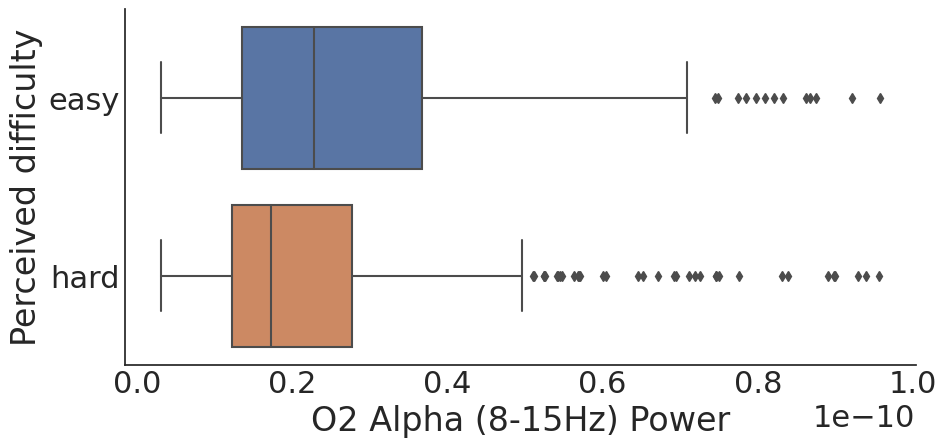

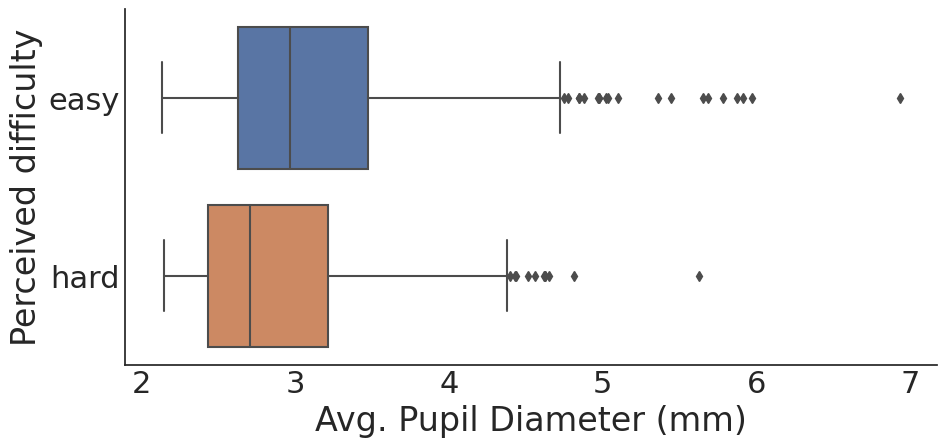

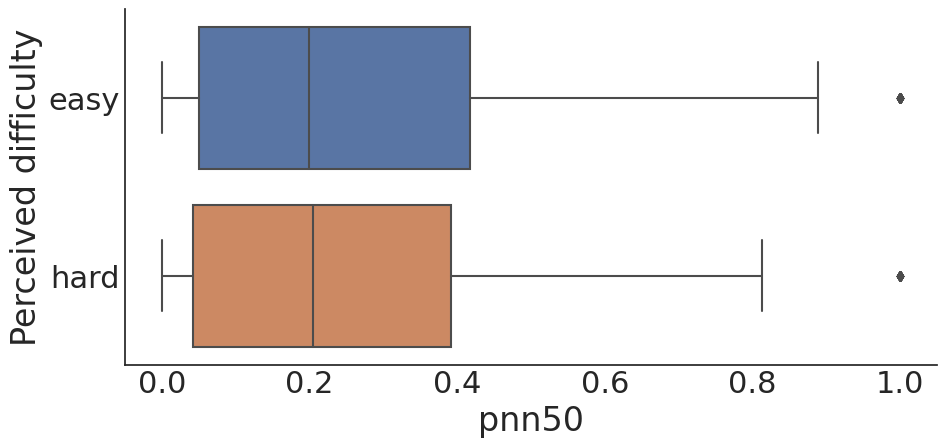

In [82]:
sns.set(font_scale=2)
plt.style.use('seaborn-white')

# some preliminary filters for data viz
coe_eeg_copy = all_dfs_final.copy()
coe_eeg_copy = coe_eeg_copy.loc[coe_eeg_copy['O2_8-15_Hz_Power'] < 1e-10]
g = sns.catplot(data=coe_eeg_copy, y="spoken_difficulty", x="O2_8-15_Hz_Power", kind="box", order=['easy','hard'], aspect=2)
g.set_axis_labels("O2 Alpha (8-15Hz) Power", "Perceived difficulty")
plt.savefig('output/coe_eeg.png', dpi=300)

coe_pupil_copy = all_dfs_final.copy()
g = sns.catplot(data=coe_pupil_copy, y="spoken_difficulty", x="Left Pupil Diameter", kind="box", order=['easy','hard'], aspect=2) # in mm
g.set_axis_labels("Avg. Pupil Diameter (mm)", "Perceived difficulty")
plt.savefig('output/coe_pupil.png', dpi=300)

coe_pnn_copy = all_dfs_final.copy()
g = sns.catplot(data=coe_pnn_copy, y="spoken_difficulty", x="pnn50", kind="box", order=['easy','hard'], aspect=2)
g.set_axis_labels("pnn50", "Perceived difficulty")
plt.savefig('output/coe_pnn.png', dpi=300)